Przepuszczamy wszystkie obrazki z każdego konceptu (binary_dataset_pelican - połowa zdjęć z konceptem i połowa bez niego) przez pipeline z pliku initial_pipeline_sae.ipynb i zapisujemy reprezentacje wyrzucone przez sae do jednego datasetu wraz z plikiem z labelami (y oznacza 1 jeśli na zdjęciu jest pelican i 0 jeśli nie ma).

Wypiszmy najpierw liczbę zdjęć z konceptem i bez niego z naszego datasetu zebranych zdjęć i zweryfikujmy, czy faktycznie znajdują się tam te koncepty (lub nie, jeśli jest to połowa bez tego konceptu.

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def image_count_and_print(dataset_path, concept_name, nr_img=3):
    '''
    Counts number of images in each class (with a concept and without it).

    Parameters:
        dataset_path - path to the dataset with images
        concept_name - name of the concept, e.g. "pelican"
        nr_img - number of images to display per class
    '''
    class_counts = {0: 0, 1: 0}
    example_images = {0: [], 1: []}

    for label_dir in ["0_other", f"1_{concept_name}"]:
        label = 0 if label_dir == "0_other" else 1
        dir_path = Path(dataset_path) / label_dir
        image_paths = [p for p in dir_path.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
        class_counts[label] = len(image_paths)
        example_images[label] = image_paths[:nr_img]

    # Liczność klas
    print(f"\nLiczność klas:")
    for label, count in class_counts.items():
        print(f"  Klasa {label}: {count} obrazów")

    # Wyświetlanie obrazów
    print(f"\nPrzykładowe obrazy (po {nr_img} na klasę):")
    fig, axes = plt.subplots(2, nr_img, figsize=(4 * nr_img, 4))
    for label in [0, 1]:
        for i, img_path in enumerate(example_images[label]):
            img = Image.open(img_path)
            axes[label][i].imshow(img)
            axes[label][i].set_title(f"Label {label}")
            axes[label][i].axis("off")
    plt.tight_layout()
    plt.show()



Liczność klas:
  Klasa 0: 1300 obrazów
  Klasa 1: 1300 obrazów

Przykładowe obrazy (po 5 na klasę):


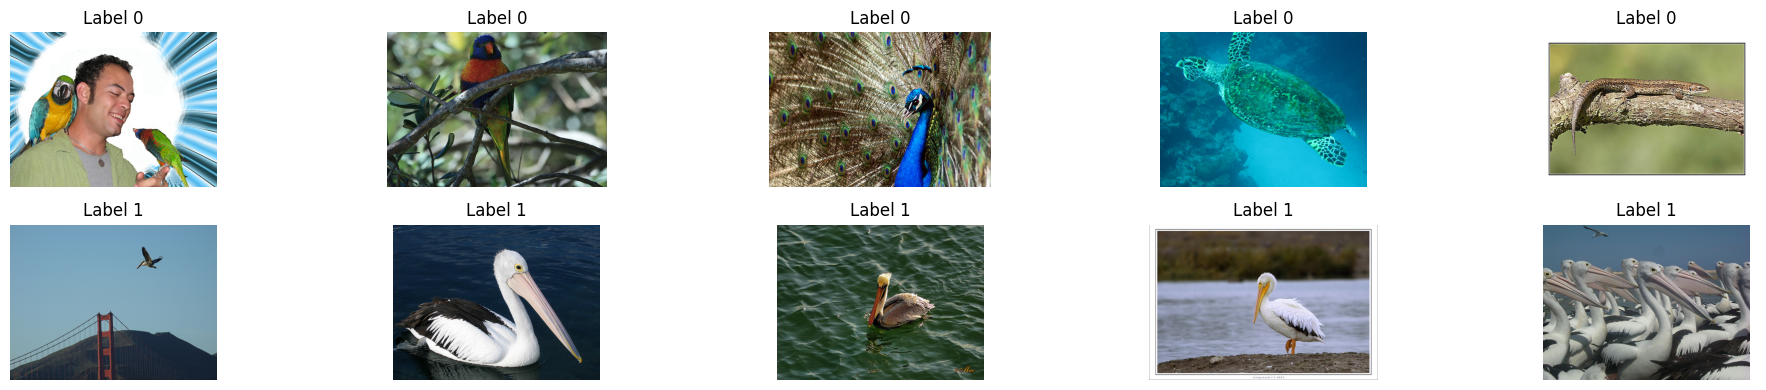

In [ ]:
image_count_and_print("../concept_datasets/binary_dataset_pelican", "pelican", 5)

In [ ]:
import torch
import clip
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path
from sparse_autoencoder import SparseAutoencoder
import pandas as pd
import numpy as np


def process_image_pipeline(image_path, sae_model_path):
    """
    Przetwarza obraz przez model CLIP i SAE, a następnie zapisuje wynik.
    :param image_path: Ścieżka do obrazu wejściowego.
    :param sae_model_path: Ścieżka do wytrenowanego modelu SAE.
    :param output_path: Ścieżka do zapisu przetworzonych cech.
    """

    # Wybór urządzenia
    device = "cuda" if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else "cpu")
    print(f"Używane urządzenie: {device}")

    # CLIP
    model, preprocess = clip.load("ViT-L/14", device=device)
    # Załaduj i przetwórz obraz
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    # Przetwarzanie obrazu przez CLIP
    with torch.no_grad():
        image_features = model.encode_image(image)

    # SAE
    def load_sae_model(sae_checkpoint_path):
        state_dict = torch.load(sae_checkpoint_path, map_location=device)
        autoencoder_input_dim = 768  # CLIP ViT-L/14
        expansion_factor = 8
        n_learned_features = int(autoencoder_input_dim * expansion_factor)
        len_hook_points = 1

        sae = SparseAutoencoder(
            n_input_features=autoencoder_input_dim,
            n_learned_features=n_learned_features,
            n_components=len_hook_points
        ).to(device)

        sae.load_state_dict(state_dict)
        sae.eval()
        return sae

    # Przepuszczanie CLIP features przez SAE
    @torch.no_grad()
    def get_sae_representation(clip_features, sae_model):
        concepts, _ = sae_model(clip_features)
        return concepts


    sae = load_sae_model(sae_model_path)
    sae_repr = get_sae_representation(image_features, sae)

    return sae_repr.cpu().squeeze(0)

In [ ]:
from tqdm import tqdm

Zróbmy (przynajmniej na razie) modele tylko na 200 zdjęciach z konceptem i 200 bez bo za długo to się wykonuje.

In [ ]:
def create_concept_dataset(dataset_path, sae_model_path, concept_name, max_per_class=200):
    X = []
    y = []

    for label_dir in ["0_other", f"1_{concept_name}"]:
        label = 0 if label_dir == "0_other" else 1
        dir_path = Path(dataset_path) / label_dir
        image_paths = [p for p in dir_path.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]


        # Bierzemy tylko do max_per_class przykładów
        image_paths = image_paths[:max_per_class]

        for img_path in tqdm(image_paths, desc=f"Processing {label_dir}"):
            try:
                vec = process_image_pipeline(img_path, sae_model_path)
                X.append(vec.squeeze().numpy())
                y.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Konwersja do tensora
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.int64)

    # Zapis
    torch.save(X_tensor, "X_concepts.pt")
    torch.save(y_tensor, "y_labels.pt")

    return X_tensor, y_tensor


In [ ]:
X, y = create_concept_dataset("../concept_datasets/binary_dataset_pelican", "clip_ViT-L_14sparse_autoencoder_final.pt", "pelican")

Processing 0_other:   0%|          | 0/200 [00:00<?, ?it/s]

Używane urządzenie: cuda



  0%|                                               | 0.00/890M [00:00<?, ?iB/s]
  1%|▏                                     | 4.80M/890M [00:00<00:18, 50.3MiB/s]
  2%|▉                                      | 20.5M/890M [00:00<00:07, 118MiB/s]
  4%|█▋                                     | 38.8M/890M [00:00<00:05, 151MiB/s]
  6%|██▎                                    | 53.2M/890M [00:00<00:06, 141MiB/s]
  8%|███                                    | 70.8M/890M [00:00<00:05, 156MiB/s]
 10%|███▊                                   | 86.6M/890M [00:00<00:05, 159MiB/s]
 11%|████▌                                   | 102M/890M [00:00<00:05, 155MiB/s]
 13%|█████▏                                  | 117M/890M [00:00<00:05, 143MiB/s]
 15%|█████▉                                  | 131M/890M [00:00<00:05, 145MiB/s]
 17%|██████▋                                 | 148M/890M [00:01<00:05, 154MiB/s]
 18%|███████▎                                | 163M/890M [00:01<00:04, 155MiB/s]
 20%|████████              

Używane urządzenie: cuda


Processing 0_other:   1%|          | 2/200 [00:49<1:19:24, 24.06s/it]

Używane urządzenie: cuda


Processing 0_other:   2%|▏         | 3/200 [01:02<1:02:45, 19.11s/it]

Używane urządzenie: cuda


Processing 0_other:   2%|▏         | 4/200 [01:15<54:37, 16.72s/it]  

Używane urządzenie: cuda


Processing 0_other:   2%|▎         | 5/200 [01:29<51:07, 15.73s/it]

Używane urządzenie: cuda


Processing 0_other:   3%|▎         | 6/200 [01:42<48:05, 14.87s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▎         | 7/200 [01:56<45:59, 14.30s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▍         | 8/200 [02:09<44:34, 13.93s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▍         | 9/200 [02:22<43:32, 13.68s/it]

Używane urządzenie: cuda


Processing 0_other:   5%|▌         | 10/200 [02:36<43:27, 13.72s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▌         | 11/200 [02:49<43:06, 13.69s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▌         | 12/200 [03:03<42:48, 13.66s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▋         | 13/200 [03:17<43:03, 13.82s/it]

Używane urządzenie: cuda


Processing 0_other:   7%|▋         | 14/200 [03:30<42:00, 13.55s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 15/200 [03:43<41:28, 13.45s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 16/200 [03:56<40:58, 13.36s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 17/200 [04:09<40:29, 13.27s/it]

Używane urządzenie: cuda


Processing 0_other:   9%|▉         | 18/200 [04:23<40:27, 13.34s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|▉         | 19/200 [04:36<40:20, 13.37s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|█         | 20/200 [04:50<39:56, 13.32s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|█         | 21/200 [05:03<39:30, 13.24s/it]

Używane urządzenie: cuda


Processing 0_other:  11%|█         | 22/200 [05:16<39:09, 13.20s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▏        | 23/200 [05:29<38:55, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▏        | 24/200 [05:42<38:52, 13.25s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▎        | 25/200 [05:56<39:12, 13.44s/it]

Używane urządzenie: cuda


Processing 0_other:  13%|█▎        | 26/200 [06:10<38:53, 13.41s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▎        | 27/200 [06:23<38:17, 13.28s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▍        | 28/200 [06:35<37:37, 13.13s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▍        | 29/200 [06:49<37:57, 13.32s/it]

Używane urządzenie: cuda


Processing 0_other:  15%|█▌        | 30/200 [07:01<36:56, 13.04s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▌        | 31/200 [07:14<36:05, 12.81s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▌        | 32/200 [07:34<41:55, 14.97s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▋        | 33/200 [07:47<40:19, 14.49s/it]

Używane urządzenie: cuda


Processing 0_other:  17%|█▋        | 34/200 [08:00<39:06, 14.13s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 35/200 [08:14<38:15, 13.91s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 36/200 [08:27<37:28, 13.71s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 37/200 [08:40<36:56, 13.60s/it]

Używane urządzenie: cuda


Processing 0_other:  19%|█▉        | 38/200 [08:54<36:24, 13.49s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|█▉        | 39/200 [09:07<36:15, 13.51s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|██        | 40/200 [09:21<35:53, 13.46s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|██        | 41/200 [09:34<35:32, 13.41s/it]

Używane urządzenie: cuda


Processing 0_other:  21%|██        | 42/200 [09:47<35:19, 13.42s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▏       | 43/200 [10:01<35:11, 13.45s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▏       | 44/200 [10:15<35:32, 13.67s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▎       | 45/200 [10:28<34:55, 13.52s/it]

Używane urządzenie: cuda


Processing 0_other:  23%|██▎       | 46/200 [10:41<34:28, 13.43s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▎       | 47/200 [10:55<34:09, 13.40s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▍       | 48/200 [11:08<33:39, 13.29s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▍       | 49/200 [11:21<33:14, 13.21s/it]

Używane urządzenie: cuda


Processing 0_other:  25%|██▌       | 50/200 [11:34<32:45, 13.10s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▌       | 51/200 [11:46<32:07, 12.94s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▌       | 52/200 [11:58<31:12, 12.66s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▋       | 53/200 [12:10<30:47, 12.56s/it]

Używane urządzenie: cuda


Processing 0_other:  27%|██▋       | 54/200 [12:23<30:48, 12.66s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 55/200 [12:37<31:03, 12.85s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 56/200 [12:49<30:40, 12.78s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 57/200 [13:02<30:44, 12.90s/it]

Używane urządzenie: cuda


Processing 0_other:  29%|██▉       | 58/200 [13:16<30:43, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|██▉       | 59/200 [13:29<30:31, 12.99s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|███       | 60/200 [13:43<31:00, 13.29s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|███       | 61/200 [13:55<30:08, 13.01s/it]

Używane urządzenie: cuda


Processing 0_other:  31%|███       | 62/200 [14:08<29:39, 12.89s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▏      | 63/200 [14:21<29:32, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▏      | 64/200 [14:34<29:25, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▎      | 65/200 [14:47<29:19, 13.03s/it]

Używane urządzenie: cuda


Processing 0_other:  33%|███▎      | 66/200 [15:00<29:27, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▎      | 67/200 [15:14<29:10, 13.16s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▍      | 68/200 [15:26<28:44, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▍      | 69/200 [15:39<28:31, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  35%|███▌      | 70/200 [15:52<28:18, 13.06s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▌      | 71/200 [16:06<28:19, 13.18s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▌      | 72/200 [16:19<28:15, 13.25s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▋      | 73/200 [16:32<27:54, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:  37%|███▋      | 74/200 [16:45<27:34, 13.13s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 75/200 [16:58<26:58, 12.95s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 76/200 [17:12<27:33, 13.34s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 77/200 [17:24<26:41, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  39%|███▉      | 78/200 [17:37<25:55, 12.75s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|███▉      | 79/200 [17:49<25:25, 12.61s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|████      | 80/200 [18:01<25:08, 12.57s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|████      | 81/200 [18:14<25:13, 12.72s/it]

Używane urządzenie: cuda


Processing 0_other:  41%|████      | 82/200 [18:28<25:18, 12.87s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▏     | 83/200 [18:41<25:16, 12.96s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▏     | 84/200 [18:54<25:11, 13.03s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▎     | 85/200 [19:07<24:56, 13.01s/it]

Używane urządzenie: cuda


Processing 0_other:  43%|████▎     | 86/200 [19:20<24:30, 12.90s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▎     | 87/200 [19:32<24:01, 12.75s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▍     | 88/200 [19:45<23:56, 12.83s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▍     | 89/200 [19:58<23:41, 12.81s/it]

Używane urządzenie: cuda


Processing 0_other:  45%|████▌     | 90/200 [20:11<23:45, 12.96s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▌     | 91/200 [20:24<23:37, 13.00s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▌     | 92/200 [20:38<23:59, 13.32s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▋     | 93/200 [20:51<23:36, 13.24s/it]

Używane urządzenie: cuda


Processing 0_other:  47%|████▋     | 94/200 [21:04<23:18, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 95/200 [21:17<23:02, 13.17s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 96/200 [21:30<22:44, 13.12s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 97/200 [21:44<22:37, 13.18s/it]

Używane urządzenie: cuda


Processing 0_other:  49%|████▉     | 98/200 [21:57<22:18, 13.13s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|████▉     | 99/200 [22:10<22:08, 13.15s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|█████     | 100/200 [22:23<21:54, 13.14s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|█████     | 101/200 [22:36<21:34, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  51%|█████     | 102/200 [22:49<21:32, 13.18s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▏    | 103/200 [23:02<21:01, 13.00s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▏    | 104/200 [23:14<20:26, 12.78s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▎    | 105/200 [23:26<19:50, 12.53s/it]

Używane urządzenie: cuda


Processing 0_other:  53%|█████▎    | 106/200 [23:39<19:38, 12.54s/it]

Używane urządzenie: cuda


Processing 0_other:  54%|█████▎    | 107/200 [23:52<19:32, 12.61s/it]

Używane urządzenie: cuda


Processing 0_other:  54%|█████▍    | 108/200 [24:05<19:38, 12.81s/it]

Używane urządzenie: cuda


Processing 0_other:  55%|█████▍    | 109/200 [24:19<20:03, 13.23s/it]

Używane urządzenie: cuda


Processing 0_other:  55%|█████▌    | 110/200 [24:32<19:48, 13.21s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▌    | 111/200 [24:46<19:38, 13.24s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▌    | 112/200 [25:00<19:46, 13.48s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▋    | 113/200 [25:13<19:24, 13.38s/it]

Używane urządzenie: cuda


Processing 0_other:  57%|█████▋    | 114/200 [25:26<19:04, 13.31s/it]

Używane urządzenie: cuda


Processing 0_other:  57%|█████▊    | 115/200 [25:39<18:47, 13.27s/it]

Używane urządzenie: cuda


Processing 0_other:  58%|█████▊    | 116/200 [25:52<18:20, 13.11s/it]

Używane urządzenie: cuda


Processing 0_other:  58%|█████▊    | 117/200 [26:04<17:51, 12.91s/it]

Używane urządzenie: cuda


Processing 0_other:  59%|█████▉    | 118/200 [26:17<17:25, 12.75s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|█████▉    | 119/200 [26:29<17:14, 12.77s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|██████    | 120/200 [26:43<17:09, 12.87s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|██████    | 121/200 [26:56<17:01, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  61%|██████    | 122/200 [27:09<16:52, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▏   | 123/200 [27:22<16:39, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▏   | 124/200 [27:35<16:27, 13.00s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▎   | 125/200 [27:49<16:52, 13.50s/it]

Używane urządzenie: cuda


Processing 0_other:  63%|██████▎   | 126/200 [28:02<16:20, 13.25s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▎   | 127/200 [28:14<15:46, 12.97s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▍   | 128/200 [28:26<15:15, 12.71s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▍   | 129/200 [28:39<14:58, 12.66s/it]

Używane urządzenie: cuda


Processing 0_other:  65%|██████▌   | 130/200 [28:52<14:50, 12.72s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▌   | 131/200 [29:05<14:43, 12.81s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▌   | 132/200 [29:18<14:40, 12.95s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▋   | 133/200 [29:31<14:28, 12.96s/it]

Używane urządzenie: cuda


Processing 0_other:  67%|██████▋   | 134/200 [29:44<14:12, 12.92s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 135/200 [29:57<13:53, 12.82s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 136/200 [30:09<13:34, 12.73s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 137/200 [30:22<13:18, 12.68s/it]

Używane urządzenie: cuda


Processing 0_other:  69%|██████▉   | 138/200 [30:35<13:14, 12.81s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|██████▉   | 139/200 [30:48<13:08, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|███████   | 140/200 [31:03<13:39, 13.65s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|███████   | 141/200 [31:17<13:23, 13.62s/it]

Używane urządzenie: cuda


Processing 0_other:  71%|███████   | 142/200 [31:31<13:21, 13.83s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▏  | 143/200 [31:44<12:47, 13.47s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▏  | 144/200 [31:57<12:23, 13.29s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▎  | 145/200 [32:10<12:07, 13.22s/it]

Używane urządzenie: cuda


Processing 0_other:  73%|███████▎  | 146/200 [32:23<11:52, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▎  | 147/200 [32:36<11:39, 13.20s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▍  | 148/200 [32:49<11:25, 13.17s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▍  | 149/200 [33:02<11:10, 13.14s/it]

Używane urządzenie: cuda


Processing 0_other:  75%|███████▌  | 150/200 [33:15<10:56, 13.14s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▌  | 151/200 [33:28<10:41, 13.10s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▌  | 152/200 [33:42<10:29, 13.12s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▋  | 153/200 [33:55<10:21, 13.22s/it]

Używane urządzenie: cuda


Processing 0_other:  77%|███████▋  | 154/200 [34:08<10:05, 13.16s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 155/200 [34:21<09:45, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 156/200 [34:33<09:25, 12.84s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 157/200 [34:45<09:03, 12.65s/it]

Używane urządzenie: cuda


Processing 0_other:  79%|███████▉  | 158/200 [34:58<08:47, 12.55s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|███████▉  | 159/200 [35:12<09:01, 13.20s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|████████  | 160/200 [35:26<08:47, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|████████  | 161/200 [35:39<08:33, 13.18s/it]

Używane urządzenie: cuda


Processing 0_other:  81%|████████  | 162/200 [35:52<08:22, 13.21s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▏ | 163/200 [36:05<08:05, 13.11s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▏ | 164/200 [36:17<07:45, 12.94s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▎ | 165/200 [36:30<07:24, 12.70s/it]

Używane urządzenie: cuda


Processing 0_other:  83%|████████▎ | 166/200 [36:42<07:11, 12.69s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▎ | 167/200 [36:55<07:03, 12.82s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▍ | 168/200 [37:08<06:50, 12.84s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▍ | 169/200 [37:21<06:40, 12.92s/it]

Używane urządzenie: cuda


Processing 0_other:  85%|████████▌ | 170/200 [37:34<06:28, 12.95s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▌ | 171/200 [37:47<06:16, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▌ | 172/200 [38:01<06:05, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▋ | 173/200 [38:14<05:52, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  87%|████████▋ | 174/200 [38:27<05:41, 13.12s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 175/200 [38:40<05:30, 13.21s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 176/200 [38:53<05:12, 13.03s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 177/200 [39:05<04:52, 12.74s/it]

Używane urządzenie: cuda


Processing 0_other:  89%|████████▉ | 178/200 [39:18<04:40, 12.74s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|████████▉ | 179/200 [39:31<04:28, 12.80s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|█████████ | 180/200 [39:44<04:17, 12.86s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|█████████ | 181/200 [39:57<04:05, 12.92s/it]

Używane urządzenie: cuda


Processing 0_other:  91%|█████████ | 182/200 [40:10<03:53, 12.96s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▏| 183/200 [40:23<03:41, 13.03s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▏| 184/200 [40:36<03:26, 12.91s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▎| 185/200 [40:48<03:12, 12.82s/it]

Używane urządzenie: cuda


Processing 0_other:  93%|█████████▎| 186/200 [41:01<02:58, 12.78s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▎| 187/200 [41:14<02:46, 12.82s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▍| 188/200 [41:27<02:34, 12.89s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▍| 189/200 [41:40<02:22, 12.91s/it]

Używane urządzenie: cuda


Processing 0_other:  95%|█████████▌| 190/200 [41:53<02:09, 12.95s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▌| 191/200 [42:08<02:02, 13.58s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▌| 192/200 [42:22<01:50, 13.84s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▋| 193/200 [42:36<01:35, 13.61s/it]

Używane urządzenie: cuda


Processing 0_other:  97%|█████████▋| 194/200 [42:49<01:21, 13.51s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 195/200 [43:02<01:06, 13.34s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 196/200 [43:15<00:53, 13.35s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 197/200 [43:28<00:39, 13.32s/it]

Używane urządzenie: cuda


Processing 0_other:  99%|█████████▉| 198/200 [43:41<00:26, 13.26s/it]

Używane urządzenie: cuda


Processing 0_other: 100%|█████████▉| 199/200 [43:55<00:13, 13.20s/it]

Używane urządzenie: cuda


Processing 1_pelican:   0%|          | 0/200 [00:00<?, ?it/s]

Używane urządzenie: cuda


Processing 1_pelican:   0%|          | 1/200 [00:12<42:11, 12.72s/it]

Używane urządzenie: cuda


Processing 1_pelican:   1%|          | 2/200 [00:25<42:21, 12.84s/it]

Używane urządzenie: cuda


Processing 1_pelican:   2%|▏         | 3/200 [00:38<42:33, 12.96s/it]

Używane urządzenie: cuda


Processing 1_pelican:   2%|▏         | 4/200 [00:52<42:47, 13.10s/it]

Używane urządzenie: cuda


Processing 1_pelican:   2%|▎         | 5/200 [01:04<42:14, 13.00s/it]

Używane urządzenie: cuda


Processing 1_pelican:   3%|▎         | 6/200 [01:18<42:25, 13.12s/it]

Używane urządzenie: cuda


Processing 1_pelican:   4%|▎         | 7/200 [01:31<42:06, 13.09s/it]

Używane urządzenie: cuda


Processing 1_pelican:   4%|▍         | 8/200 [01:44<42:00, 13.13s/it]

Używane urządzenie: cuda


Processing 1_pelican:   4%|▍         | 9/200 [01:58<42:37, 13.39s/it]

Używane urządzenie: cuda


Processing 1_pelican:   5%|▌         | 10/200 [02:11<42:22, 13.38s/it]

Używane urządzenie: cuda


Processing 1_pelican:   6%|▌         | 11/200 [02:25<42:05, 13.36s/it]

Używane urządzenie: cuda


Processing 1_pelican:   6%|▌         | 12/200 [02:38<42:09, 13.45s/it]

Używane urządzenie: cuda


Processing 1_pelican:   6%|▋         | 13/200 [02:51<41:36, 13.35s/it]

Używane urządzenie: cuda


Processing 1_pelican:   7%|▋         | 14/200 [03:04<41:08, 13.27s/it]

Używane urządzenie: cuda


Processing 1_pelican:   8%|▊         | 15/200 [03:17<40:37, 13.17s/it]

Używane urządzenie: cuda


Processing 1_pelican:   8%|▊         | 16/200 [03:30<39:58, 13.04s/it]

Używane urządzenie: cuda


Processing 1_pelican:   8%|▊         | 17/200 [03:42<39:07, 12.83s/it]

Używane urządzenie: cuda


Processing 1_pelican:   9%|▉         | 18/200 [03:54<37:57, 12.52s/it]

Używane urządzenie: cuda


Processing 1_pelican:  10%|▉         | 19/200 [04:07<37:46, 12.52s/it]

Używane urządzenie: cuda


Processing 1_pelican:  10%|█         | 20/200 [04:20<37:54, 12.64s/it]

Używane urządzenie: cuda


Processing 1_pelican:  10%|█         | 21/200 [04:33<38:05, 12.77s/it]

Używane urządzenie: cuda


Processing 1_pelican:  11%|█         | 22/200 [04:46<38:22, 12.93s/it]

Używane urządzenie: cuda


Processing 1_pelican:  12%|█▏        | 23/200 [04:59<38:20, 12.99s/it]

Używane urządzenie: cuda


Processing 1_pelican:  12%|█▏        | 24/200 [05:12<38:13, 13.03s/it]

Używane urządzenie: cuda


Processing 1_pelican:  12%|█▎        | 25/200 [05:25<37:52, 12.99s/it]

Używane urządzenie: cuda


Processing 1_pelican:  13%|█▎        | 26/200 [05:40<38:50, 13.39s/it]

Używane urządzenie: cuda


Processing 1_pelican:  14%|█▎        | 27/200 [05:52<37:47, 13.11s/it]

Używane urządzenie: cuda


Processing 1_pelican:  14%|█▍        | 28/200 [06:05<37:15, 12.99s/it]

Używane urządzenie: cuda


Processing 1_pelican:  14%|█▍        | 29/200 [06:18<37:16, 13.08s/it]

Używane urządzenie: cuda


Processing 1_pelican:  15%|█▌        | 30/200 [06:31<36:52, 13.01s/it]

Używane urządzenie: cuda


Processing 1_pelican:  16%|█▌        | 31/200 [06:44<36:37, 13.00s/it]

Używane urządzenie: cuda


Processing 1_pelican:  16%|█▌        | 32/200 [06:57<36:24, 13.00s/it]

Używane urządzenie: cuda


Processing 1_pelican:  16%|█▋        | 33/200 [07:10<36:27, 13.10s/it]

Używane urządzenie: cuda


Processing 1_pelican:  17%|█▋        | 34/200 [07:23<36:19, 13.13s/it]

Używane urządzenie: cuda


Processing 1_pelican:  18%|█▊        | 35/200 [07:37<36:17, 13.20s/it]

Używane urządzenie: cuda


Processing 1_pelican:  18%|█▊        | 36/200 [07:50<36:01, 13.18s/it]

Używane urządzenie: cuda


Processing 1_pelican:  18%|█▊        | 37/200 [08:03<35:49, 13.19s/it]

Używane urządzenie: cuda


Processing 1_pelican:  19%|█▉        | 38/200 [08:16<35:32, 13.17s/it]

Używane urządzenie: cuda


Processing 1_pelican:  20%|█▉        | 39/200 [08:29<35:20, 13.17s/it]

Używane urządzenie: cuda


Processing 1_pelican:  20%|██        | 40/200 [08:42<35:01, 13.13s/it]

Używane urządzenie: cuda


Processing 1_pelican:  20%|██        | 41/200 [08:55<34:20, 12.96s/it]

Używane urządzenie: cuda


Processing 1_pelican:  21%|██        | 42/200 [09:07<33:37, 12.77s/it]

Używane urządzenie: cuda


Processing 1_pelican:  22%|██▏       | 43/200 [09:21<34:27, 13.17s/it]

Używane urządzenie: cuda


Processing 1_pelican:  22%|██▏       | 44/200 [09:33<33:16, 12.80s/it]

Używane urządzenie: cuda


Processing 1_pelican:  22%|██▎       | 45/200 [09:46<32:40, 12.65s/it]

Używane urządzenie: cuda


Processing 1_pelican:  23%|██▎       | 46/200 [09:58<32:14, 12.56s/it]

Używane urządzenie: cuda


Processing 1_pelican:  24%|██▎       | 47/200 [10:10<31:46, 12.46s/it]

Używane urządzenie: cuda


Processing 1_pelican:  24%|██▍       | 48/200 [10:24<32:29, 12.83s/it]

Używane urządzenie: cuda


Processing 1_pelican:  24%|██▍       | 49/200 [10:37<32:22, 12.86s/it]

Używane urządzenie: cuda


Processing 1_pelican:  25%|██▌       | 50/200 [10:49<31:54, 12.77s/it]

Używane urządzenie: cuda


Processing 1_pelican:  26%|██▌       | 51/200 [11:02<31:32, 12.70s/it]

Używane urządzenie: cuda


Processing 1_pelican:  26%|██▌       | 52/200 [11:15<31:24, 12.73s/it]

Używane urządzenie: cuda


Processing 1_pelican:  26%|██▋       | 53/200 [11:28<31:33, 12.88s/it]

Używane urządzenie: cuda


Processing 1_pelican:  27%|██▋       | 54/200 [11:41<31:28, 12.93s/it]

Używane urządzenie: cuda


Processing 1_pelican:  28%|██▊       | 55/200 [11:54<31:22, 12.98s/it]

Używane urządzenie: cuda


Processing 1_pelican:  28%|██▊       | 56/200 [12:07<31:23, 13.08s/it]

Używane urządzenie: cuda


Processing 1_pelican:  28%|██▊       | 57/200 [12:21<31:19, 13.14s/it]

Używane urządzenie: cuda


Processing 1_pelican:  29%|██▉       | 58/200 [12:34<31:09, 13.17s/it]

Używane urządzenie: cuda


Processing 1_pelican:  30%|██▉       | 59/200 [12:47<30:58, 13.18s/it]

Używane urządzenie: cuda


Processing 1_pelican:  30%|███       | 60/200 [13:02<31:41, 13.58s/it]

Używane urządzenie: cuda


Processing 1_pelican:  30%|███       | 61/200 [13:15<31:09, 13.45s/it]

Używane urządzenie: cuda


Processing 1_pelican:  31%|███       | 62/200 [13:27<30:21, 13.20s/it]

Używane urządzenie: cuda


Processing 1_pelican:  32%|███▏      | 63/200 [13:40<29:27, 12.90s/it]

Używane urządzenie: cuda


Processing 1_pelican:  32%|███▏      | 64/200 [13:52<28:46, 12.69s/it]

Używane urządzenie: cuda


Processing 1_pelican:  32%|███▎      | 65/200 [14:05<28:38, 12.73s/it]

Używane urządzenie: cuda


Processing 1_pelican:  33%|███▎      | 66/200 [14:18<28:34, 12.80s/it]

Używane urządzenie: cuda


Processing 1_pelican:  34%|███▎      | 67/200 [14:31<28:52, 13.02s/it]

Używane urządzenie: cuda


Processing 1_pelican:  34%|███▍      | 68/200 [14:46<29:51, 13.57s/it]

Używane urządzenie: cuda


Processing 1_pelican:  34%|███▍      | 69/200 [14:58<28:42, 13.15s/it]

Używane urządzenie: cuda


Processing 1_pelican:  35%|███▌      | 70/200 [15:11<28:25, 13.12s/it]

Używane urządzenie: cuda


Processing 1_pelican:  36%|███▌      | 71/200 [15:25<28:23, 13.21s/it]

Używane urządzenie: cuda


Processing 1_pelican:  36%|███▌      | 72/200 [15:38<28:01, 13.14s/it]

Używane urządzenie: cuda


Processing 1_pelican:  36%|███▋      | 73/200 [15:51<27:48, 13.14s/it]

Używane urządzenie: cuda


Processing 1_pelican:  37%|███▋      | 74/200 [16:04<27:24, 13.05s/it]

Używane urządzenie: cuda


Processing 1_pelican:  38%|███▊      | 75/200 [16:16<26:56, 12.94s/it]

Używane urządzenie: cuda


Processing 1_pelican:  38%|███▊      | 76/200 [16:29<26:44, 12.94s/it]

Używane urządzenie: cuda


Processing 1_pelican:  38%|███▊      | 77/200 [16:42<26:25, 12.89s/it]

Używane urządzenie: cuda


Processing 1_pelican:  39%|███▉      | 78/200 [16:56<26:43, 13.14s/it]

Używane urządzenie: cuda


Processing 1_pelican:  40%|███▉      | 79/200 [17:09<26:21, 13.07s/it]

Używane urządzenie: cuda


Processing 1_pelican:  40%|████      | 80/200 [17:22<26:08, 13.07s/it]

Używane urządzenie: cuda


Processing 1_pelican:  40%|████      | 81/200 [17:35<25:56, 13.08s/it]

Używane urządzenie: cuda


Processing 1_pelican:  41%|████      | 82/200 [17:48<25:45, 13.10s/it]

Używane urządzenie: cuda


Processing 1_pelican:  42%|████▏     | 83/200 [18:01<25:33, 13.11s/it]

Używane urządzenie: cuda


Processing 1_pelican:  42%|████▏     | 84/200 [18:14<25:25, 13.15s/it]

Używane urządzenie: cuda


Processing 1_pelican:  42%|████▎     | 85/200 [18:28<25:15, 13.18s/it]

Używane urządzenie: cuda


Processing 1_pelican:  43%|████▎     | 86/200 [18:41<25:05, 13.20s/it]

Używane urządzenie: cuda


Processing 1_pelican:  44%|████▎     | 87/200 [18:54<24:54, 13.22s/it]

Używane urządzenie: cuda


Processing 1_pelican:  44%|████▍     | 88/200 [19:07<24:43, 13.25s/it]

Używane urządzenie: cuda


Processing 1_pelican:  44%|████▍     | 89/200 [19:21<24:41, 13.35s/it]

Używane urządzenie: cuda


Processing 1_pelican:  45%|████▌     | 90/200 [19:34<24:24, 13.32s/it]

Używane urządzenie: cuda


Processing 1_pelican:  46%|████▌     | 91/200 [19:47<24:08, 13.29s/it]

Używane urządzenie: cuda


Processing 1_pelican:  46%|████▌     | 92/200 [20:01<23:46, 13.21s/it]

Używane urządzenie: cuda


Processing 1_pelican:  46%|████▋     | 93/200 [20:13<23:15, 13.04s/it]

Używane urządzenie: cuda


Processing 1_pelican:  47%|████▋     | 94/200 [20:25<22:35, 12.79s/it]

Używane urządzenie: cuda


Processing 1_pelican:  48%|████▊     | 95/200 [20:39<22:53, 13.08s/it]

Używane urządzenie: cuda


Processing 1_pelican:  48%|████▊     | 96/200 [20:51<22:05, 12.75s/it]

Używane urządzenie: cuda


Processing 1_pelican:  48%|████▊     | 97/200 [21:04<21:44, 12.67s/it]

Używane urządzenie: cuda


Processing 1_pelican:  49%|████▉     | 98/200 [21:16<21:36, 12.71s/it]

Używane urządzenie: cuda


Processing 1_pelican:  50%|████▉     | 99/200 [21:30<21:36, 12.84s/it]

Używane urządzenie: cuda


Processing 1_pelican:  50%|█████     | 100/200 [21:43<21:45, 13.05s/it]

Używane urządzenie: cuda


Processing 1_pelican:  50%|█████     | 101/200 [21:56<21:32, 13.06s/it]

Używane urządzenie: cuda


Processing 1_pelican:  51%|█████     | 102/200 [22:09<21:26, 13.13s/it]

Używane urządzenie: cuda


Processing 1_pelican:  52%|█████▏    | 103/200 [22:23<21:12, 13.12s/it]

Używane urządzenie: cuda


Processing 1_pelican:  52%|█████▏    | 104/200 [22:36<20:56, 13.09s/it]

Używane urządzenie: cuda


Processing 1_pelican:  52%|█████▎    | 105/200 [22:48<20:31, 12.96s/it]

Używane urządzenie: cuda


Processing 1_pelican:  53%|█████▎    | 106/200 [23:00<19:59, 12.76s/it]

Używane urządzenie: cuda


Processing 1_pelican:  54%|█████▎    | 107/200 [23:13<19:41, 12.71s/it]

Używane urządzenie: cuda


Processing 1_pelican:  54%|█████▍    | 108/200 [23:26<19:39, 12.82s/it]

Używane urządzenie: cuda


Processing 1_pelican:  55%|█████▍    | 109/200 [23:39<19:33, 12.90s/it]

Używane urządzenie: cuda


Processing 1_pelican:  55%|█████▌    | 110/200 [23:52<19:24, 12.94s/it]

Używane urządzenie: cuda


Processing 1_pelican:  56%|█████▌    | 111/200 [24:05<19:18, 13.01s/it]

Używane urządzenie: cuda


Processing 1_pelican:  56%|█████▌    | 112/200 [24:19<19:12, 13.09s/it]

Używane urządzenie: cuda


Processing 1_pelican:  56%|█████▋    | 113/200 [24:33<19:23, 13.37s/it]

Używane urządzenie: cuda


Processing 1_pelican:  57%|█████▋    | 114/200 [24:46<19:02, 13.28s/it]

Używane urządzenie: cuda


Processing 1_pelican:  57%|█████▊    | 115/200 [24:59<18:43, 13.21s/it]

Używane urządzenie: cuda


Processing 1_pelican:  58%|█████▊    | 116/200 [25:12<18:27, 13.19s/it]

Używane urządzenie: cuda


Processing 1_pelican:  58%|█████▊    | 117/200 [25:25<18:09, 13.13s/it]

Używane urządzenie: cuda


Processing 1_pelican:  59%|█████▉    | 118/200 [25:38<17:57, 13.14s/it]

Używane urządzenie: cuda


Processing 1_pelican:  60%|█████▉    | 119/200 [25:51<17:41, 13.11s/it]

Używane urządzenie: cuda


Processing 1_pelican:  60%|██████    | 120/200 [26:04<17:27, 13.09s/it]

Używane urządzenie: cuda


Processing 1_pelican:  60%|██████    | 121/200 [26:16<16:48, 12.77s/it]

Używane urządzenie: cuda


Processing 1_pelican:  61%|██████    | 122/200 [26:29<16:23, 12.61s/it]

Używane urządzenie: cuda


Processing 1_pelican:  62%|██████▏   | 123/200 [26:41<16:00, 12.47s/it]

Używane urządzenie: cuda


Processing 1_pelican:  62%|██████▏   | 124/200 [26:53<15:54, 12.56s/it]

Używane urządzenie: cuda


Processing 1_pelican:  62%|██████▎   | 125/200 [27:06<15:52, 12.71s/it]

Używane urządzenie: cuda


Processing 1_pelican:  63%|██████▎   | 126/200 [27:20<15:52, 12.88s/it]

Używane urządzenie: cuda


Processing 1_pelican:  64%|██████▎   | 127/200 [27:34<16:20, 13.44s/it]

Używane urządzenie: cuda


Processing 1_pelican:  64%|██████▍   | 128/200 [27:48<16:03, 13.38s/it]

Używane urządzenie: cuda


Processing 1_pelican:  64%|██████▍   | 129/200 [28:01<15:42, 13.28s/it]

Używane urządzenie: cuda


Processing 1_pelican:  65%|██████▌   | 130/200 [28:15<15:54, 13.64s/it]

Używane urządzenie: cuda


Processing 1_pelican:  66%|██████▌   | 131/200 [28:28<15:20, 13.34s/it]

Używane urządzenie: cuda


Processing 1_pelican:  66%|██████▌   | 132/200 [28:41<15:01, 13.25s/it]

Używane urządzenie: cuda


Processing 1_pelican:  66%|██████▋   | 133/200 [28:54<14:43, 13.19s/it]

Używane urządzenie: cuda


Processing 1_pelican:  67%|██████▋   | 134/200 [29:07<14:23, 13.08s/it]

Używane urządzenie: cuda


Processing 1_pelican:  68%|██████▊   | 135/200 [29:20<14:07, 13.03s/it]

Używane urządzenie: cuda


Processing 1_pelican:  68%|██████▊   | 136/200 [29:32<13:46, 12.91s/it]

Używane urządzenie: cuda


Processing 1_pelican:  68%|██████▊   | 137/200 [29:45<13:33, 12.91s/it]

Używane urządzenie: cuda


Processing 1_pelican:  69%|██████▉   | 138/200 [29:58<13:12, 12.79s/it]

Używane urządzenie: cuda


Processing 1_pelican:  70%|██████▉   | 139/200 [30:11<13:09, 12.94s/it]

Używane urządzenie: cuda


Processing 1_pelican:  70%|███████   | 140/200 [30:24<12:57, 12.95s/it]

Używane urządzenie: cuda


Processing 1_pelican:  70%|███████   | 141/200 [30:37<12:44, 12.95s/it]

Używane urządzenie: cuda


Processing 1_pelican:  71%|███████   | 142/200 [30:50<12:35, 13.03s/it]

Używane urządzenie: cuda


Processing 1_pelican:  72%|███████▏  | 143/200 [31:03<12:25, 13.08s/it]

Używane urządzenie: cuda


Processing 1_pelican:  72%|███████▏  | 144/200 [31:17<12:12, 13.08s/it]

Używane urządzenie: cuda


Processing 1_pelican:  72%|███████▎  | 145/200 [31:30<11:58, 13.07s/it]

Używane urządzenie: cuda


Processing 1_pelican:  73%|███████▎  | 146/200 [31:43<11:51, 13.18s/it]

Używane urządzenie: cuda


Processing 1_pelican:  74%|███████▎  | 147/200 [31:56<11:37, 13.16s/it]

Używane urządzenie: cuda


Processing 1_pelican:  74%|███████▍  | 148/200 [32:10<11:38, 13.44s/it]

Używane urządzenie: cuda


Processing 1_pelican:  74%|███████▍  | 149/200 [32:23<11:21, 13.36s/it]

Używane urządzenie: cuda


Processing 1_pelican:  75%|███████▌  | 150/200 [32:36<11:03, 13.26s/it]

Używane urządzenie: cuda


Processing 1_pelican:  76%|███████▌  | 151/200 [32:50<10:48, 13.22s/it]

Używane urządzenie: cuda


Processing 1_pelican:  76%|███████▌  | 152/200 [33:03<10:32, 13.17s/it]

Używane urządzenie: cuda


Processing 1_pelican:  76%|███████▋  | 153/200 [33:15<10:11, 13.01s/it]

Używane urządzenie: cuda


Processing 1_pelican:  77%|███████▋  | 154/200 [33:27<09:47, 12.77s/it]

Używane urządzenie: cuda


Processing 1_pelican:  78%|███████▊  | 155/200 [33:39<09:24, 12.54s/it]

Używane urządzenie: cuda


Processing 1_pelican:  78%|███████▊  | 156/200 [33:52<09:11, 12.53s/it]

Używane urządzenie: cuda


Processing 1_pelican:  78%|███████▊  | 157/200 [34:05<09:03, 12.63s/it]

Używane urządzenie: cuda


Processing 1_pelican:  79%|███████▉  | 158/200 [34:19<09:05, 12.99s/it]

Używane urządzenie: cuda


Processing 1_pelican:  80%|███████▉  | 159/200 [34:32<08:52, 12.99s/it]

Używane urządzenie: cuda


Processing 1_pelican:  80%|████████  | 160/200 [34:44<08:37, 12.94s/it]

Używane urządzenie: cuda


Processing 1_pelican:  80%|████████  | 161/200 [34:57<08:24, 12.95s/it]

Używane urządzenie: cuda


Processing 1_pelican:  81%|████████  | 162/200 [35:10<08:08, 12.84s/it]

Używane urządzenie: cuda


Processing 1_pelican:  82%|████████▏ | 163/200 [35:22<07:46, 12.60s/it]

Używane urządzenie: cuda


Processing 1_pelican:  82%|████████▏ | 164/200 [35:35<07:35, 12.66s/it]

Używane urządzenie: cuda


Processing 1_pelican:  82%|████████▎ | 165/200 [35:48<07:27, 12.79s/it]

Używane urządzenie: cuda


Processing 1_pelican:  83%|████████▎ | 166/200 [36:02<07:28, 13.19s/it]

Używane urządzenie: cuda


Processing 1_pelican:  84%|████████▎ | 167/200 [36:15<07:17, 13.26s/it]

Używane urządzenie: cuda


Processing 1_pelican:  84%|████████▍ | 168/200 [36:29<07:03, 13.22s/it]

Używane urządzenie: cuda


Processing 1_pelican:  84%|████████▍ | 169/200 [36:42<06:47, 13.13s/it]

Używane urządzenie: cuda


Processing 1_pelican:  85%|████████▌ | 170/200 [36:55<06:33, 13.12s/it]

Używane urządzenie: cuda


Processing 1_pelican:  86%|████████▌ | 171/200 [37:08<06:19, 13.09s/it]

Używane urządzenie: cuda


Processing 1_pelican:  86%|████████▌ | 172/200 [37:21<06:06, 13.10s/it]

Używane urządzenie: cuda


Processing 1_pelican:  86%|████████▋ | 173/200 [37:34<05:52, 13.06s/it]

Używane urządzenie: cuda


Processing 1_pelican:  87%|████████▋ | 174/200 [37:47<05:37, 12.98s/it]

Używane urządzenie: cuda


Processing 1_pelican:  88%|████████▊ | 175/200 [37:59<05:19, 12.80s/it]

Używane urządzenie: cuda


Processing 1_pelican:  88%|████████▊ | 176/200 [38:11<05:00, 12.52s/it]

Używane urządzenie: cuda


Processing 1_pelican:  88%|████████▊ | 177/200 [38:23<04:46, 12.45s/it]

Używane urządzenie: cuda


Processing 1_pelican:  89%|████████▉ | 178/200 [38:36<04:34, 12.48s/it]

Używane urządzenie: cuda


Processing 1_pelican:  90%|████████▉ | 179/200 [38:49<04:25, 12.63s/it]

Używane urządzenie: cuda


Processing 1_pelican:  90%|█████████ | 180/200 [39:02<04:18, 12.90s/it]

Używane urządzenie: cuda


Processing 1_pelican:  90%|█████████ | 181/200 [39:15<04:06, 12.99s/it]

Używane urządzenie: cuda


Processing 1_pelican:  91%|█████████ | 182/200 [39:28<03:54, 13.03s/it]

Używane urządzenie: cuda


Processing 1_pelican:  92%|█████████▏| 183/200 [39:41<03:40, 12.95s/it]

Używane urządzenie: cuda


Processing 1_pelican:  92%|█████████▏| 184/200 [39:55<03:31, 13.19s/it]

Używane urządzenie: cuda


Processing 1_pelican:  92%|█████████▎| 185/200 [40:08<03:15, 13.03s/it]

Używane urządzenie: cuda


Processing 1_pelican:  93%|█████████▎| 186/200 [40:20<02:59, 12.81s/it]

Używane urządzenie: cuda


Processing 1_pelican:  94%|█████████▎| 187/200 [40:33<02:46, 12.79s/it]

Używane urządzenie: cuda


Processing 1_pelican:  94%|█████████▍| 188/200 [40:46<02:34, 12.84s/it]

Używane urządzenie: cuda


Processing 1_pelican:  94%|█████████▍| 189/200 [40:59<02:22, 12.91s/it]

Używane urządzenie: cuda


Processing 1_pelican:  95%|█████████▌| 190/200 [41:12<02:09, 12.95s/it]

Używane urządzenie: cuda


Processing 1_pelican:  96%|█████████▌| 191/200 [41:25<01:56, 13.00s/it]

Używane urządzenie: cuda


Processing 1_pelican:  96%|█████████▌| 192/200 [41:38<01:44, 13.02s/it]

Używane urządzenie: cuda


Processing 1_pelican:  96%|█████████▋| 193/200 [41:51<01:31, 13.12s/it]

Używane urządzenie: cuda


Processing 1_pelican:  97%|█████████▋| 194/200 [42:04<01:18, 13.10s/it]

Używane urządzenie: cuda


Processing 1_pelican:  98%|█████████▊| 195/200 [42:17<01:05, 13.09s/it]

Używane urządzenie: cuda


Processing 1_pelican:  98%|█████████▊| 196/200 [42:30<00:52, 13.01s/it]

Używane urządzenie: cuda


Processing 1_pelican:  98%|█████████▊| 197/200 [42:43<00:38, 12.83s/it]

Używane urządzenie: cuda


Processing 1_pelican:  99%|█████████▉| 198/200 [42:55<00:25, 12.57s/it]

Używane urządzenie: cuda


Processing 1_pelican: 100%|█████████▉| 199/200 [43:07<00:12, 12.43s/it]

Używane urządzenie: cuda


Processing 1_pelican: 100%|██████████| 200/200 [43:20<00:00, 13.00s/it]
<ipython-input-3-8f9e9be1d0f8>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_tensor = torch.tensor(X, dtype=torch.float32)


To samo dla 2 pozostałych konceptów: flamingi i gęsi.

Flamingi:


Liczność klas:
  Klasa 0: 1300 obrazów
  Klasa 1: 1300 obrazów

Przykładowe obrazy (po 5 na klasę):


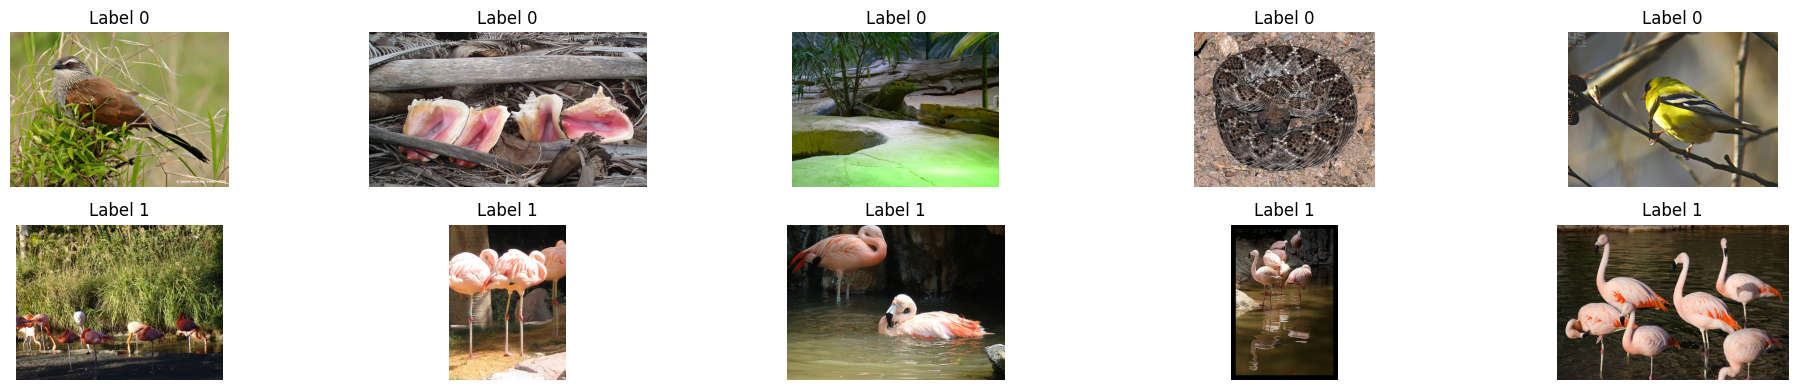

In [ ]:
image_count_and_print("../concept_datasets/binary_dataset_flamingos", "flamingo", 5)

In [ ]:
X_flamingo, y_flamingo = create_concept_dataset("../concept_datasets/binary_dataset_flamingos", "clip_ViT-L_14sparse_autoencoder_final.pt", "flamingo")

Processing 0_other:   0%|          | 0/200 [00:00<?, ?it/s]

Używane urządzenie: cuda


<ipython-input-1-99949ebacc2a>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(sae_checkpoint_path, map_location=device)
Processing 0_other:   0%| 

Używane urządzenie: cuda


Processing 0_other:   1%|          | 2/200 [00:26<43:02, 13.04s/it]

Używane urządzenie: cuda


Processing 0_other:   2%|▏         | 3/200 [00:38<41:33, 12.66s/it]

Używane urządzenie: cuda


Processing 0_other:   2%|▏         | 4/200 [00:50<40:14, 12.32s/it]

Używane urządzenie: cuda


Processing 0_other:   2%|▎         | 5/200 [01:02<40:00, 12.31s/it]

Używane urządzenie: cuda


Processing 0_other:   3%|▎         | 6/200 [01:15<40:23, 12.49s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▎         | 7/200 [01:28<41:06, 12.78s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▍         | 8/200 [01:43<42:39, 13.33s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▍         | 9/200 [01:55<41:42, 13.10s/it]

Używane urządzenie: cuda


Processing 0_other:   5%|▌         | 10/200 [02:08<41:24, 13.08s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▌         | 11/200 [02:21<41:12, 13.08s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▌         | 12/200 [02:35<41:08, 13.13s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▋         | 13/200 [02:48<40:45, 13.08s/it]

Używane urządzenie: cuda


Processing 0_other:   7%|▋         | 14/200 [03:01<41:06, 13.26s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 15/200 [03:14<40:39, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 16/200 [03:27<39:43, 12.96s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 17/200 [03:39<38:53, 12.75s/it]

Używane urządzenie: cuda


Processing 0_other:   9%|▉         | 18/200 [03:52<38:37, 12.73s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|▉         | 19/200 [04:05<38:29, 12.76s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|█         | 20/200 [04:18<38:29, 12.83s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|█         | 21/200 [04:31<38:27, 12.89s/it]

Używane urządzenie: cuda


Processing 0_other:  11%|█         | 22/200 [04:43<38:12, 12.88s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▏        | 23/200 [04:56<38:05, 12.91s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▏        | 24/200 [05:11<39:39, 13.52s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▎        | 25/200 [05:31<44:19, 15.20s/it]

Używane urządzenie: cuda


Processing 0_other:  13%|█▎        | 26/200 [05:45<43:14, 14.91s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▎        | 27/200 [05:57<40:49, 14.16s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▍        | 28/200 [06:10<39:14, 13.69s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▍        | 29/200 [06:22<38:11, 13.40s/it]

Używane urządzenie: cuda


Processing 0_other:  15%|█▌        | 30/200 [06:35<37:32, 13.25s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▌        | 31/200 [06:49<37:13, 13.22s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▌        | 32/200 [07:03<37:48, 13.50s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▋        | 33/200 [07:16<37:10, 13.35s/it]

Używane urządzenie: cuda


Processing 0_other:  17%|█▋        | 34/200 [07:29<36:42, 13.27s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 35/200 [07:42<36:18, 13.20s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 36/200 [07:55<36:00, 13.17s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 37/200 [08:08<35:54, 13.22s/it]

Używane urządzenie: cuda


Processing 0_other:  19%|█▉        | 38/200 [08:22<35:48, 13.26s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|█▉        | 39/200 [08:35<35:26, 13.21s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|██        | 40/200 [08:48<35:12, 13.20s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|██        | 41/200 [09:01<35:13, 13.29s/it]

Używane urządzenie: cuda


Processing 0_other:  21%|██        | 42/200 [09:15<35:01, 13.30s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▏       | 43/200 [09:27<34:24, 13.15s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▏       | 44/200 [09:41<34:37, 13.32s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▎       | 45/200 [09:54<34:09, 13.22s/it]

Używane urządzenie: cuda


Processing 0_other:  23%|██▎       | 46/200 [10:06<33:11, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▎       | 47/200 [10:19<32:21, 12.69s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▍       | 48/200 [10:31<31:57, 12.61s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▍       | 49/200 [10:44<31:55, 12.69s/it]

Używane urządzenie: cuda


Processing 0_other:  25%|██▌       | 50/200 [10:57<32:20, 12.94s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▌       | 51/200 [11:11<32:19, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▌       | 52/200 [11:24<32:14, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▋       | 53/200 [11:37<31:58, 13.05s/it]

Używane urządzenie: cuda


Processing 0_other:  27%|██▋       | 54/200 [11:49<31:30, 12.95s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 55/200 [12:02<30:52, 12.77s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 56/200 [12:15<30:36, 12.76s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 57/200 [12:28<30:33, 12.82s/it]

Używane urządzenie: cuda


Processing 0_other:  29%|██▉       | 58/200 [12:41<30:30, 12.89s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|██▉       | 59/200 [12:54<30:35, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|███       | 60/200 [13:07<30:25, 13.04s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|███       | 61/200 [13:20<30:15, 13.06s/it]

Używane urządzenie: cuda


Processing 0_other:  31%|███       | 62/200 [13:34<30:53, 13.43s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▏      | 63/200 [13:48<30:38, 13.42s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▏      | 64/200 [14:01<29:58, 13.22s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▎      | 65/200 [14:13<28:57, 12.87s/it]

Używane urządzenie: cuda


Processing 0_other:  33%|███▎      | 66/200 [14:25<28:16, 12.66s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▎      | 67/200 [14:37<27:47, 12.54s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▍      | 68/200 [14:50<27:49, 12.65s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▍      | 69/200 [15:03<27:58, 12.81s/it]

Używane urządzenie: cuda


Processing 0_other:  35%|███▌      | 70/200 [15:16<28:01, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▌      | 71/200 [15:29<27:54, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▌      | 72/200 [15:42<27:35, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▋      | 73/200 [15:55<27:09, 12.83s/it]

Używane urządzenie: cuda


Processing 0_other:  37%|███▋      | 74/200 [16:08<26:55, 12.82s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 75/200 [16:20<26:38, 12.78s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 76/200 [16:33<26:25, 12.79s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 77/200 [16:46<26:22, 12.87s/it]

Używane urządzenie: cuda


Processing 0_other:  39%|███▉      | 78/200 [16:59<26:18, 12.94s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|███▉      | 79/200 [17:12<26:10, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|████      | 80/200 [17:26<26:02, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|████      | 81/200 [17:39<26:23, 13.30s/it]

Używane urządzenie: cuda


Processing 0_other:  41%|████      | 82/200 [17:53<26:03, 13.25s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▏     | 83/200 [18:06<25:49, 13.25s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▏     | 84/200 [18:19<25:30, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▎     | 85/200 [18:32<25:27, 13.28s/it]

Używane urządzenie: cuda


Processing 0_other:  43%|████▎     | 86/200 [18:45<25:04, 13.20s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▎     | 87/200 [18:58<24:25, 12.97s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▍     | 88/200 [19:10<23:42, 12.70s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▍     | 89/200 [19:22<23:11, 12.54s/it]

Używane urządzenie: cuda


Processing 0_other:  45%|████▌     | 90/200 [19:35<23:06, 12.60s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▌     | 91/200 [19:48<23:15, 12.80s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▌     | 92/200 [20:01<23:12, 12.90s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▋     | 93/200 [20:15<23:13, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  47%|████▋     | 94/200 [20:28<23:06, 13.08s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 95/200 [20:41<22:59, 13.14s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 96/200 [20:54<22:43, 13.12s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 97/200 [21:07<22:14, 12.95s/it]

Używane urządzenie: cuda


Processing 0_other:  49%|████▉     | 98/200 [21:19<21:48, 12.83s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|████▉     | 99/200 [21:33<22:19, 13.26s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|█████     | 100/200 [21:46<21:46, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|█████     | 101/200 [21:59<21:28, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  51%|█████     | 102/200 [22:12<21:21, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▏    | 103/200 [22:25<21:08, 13.08s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▏    | 104/200 [22:38<20:53, 13.06s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▎    | 105/200 [22:51<20:42, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  53%|█████▎    | 106/200 [23:05<20:34, 13.13s/it]

Używane urządzenie: cuda


Processing 0_other:  54%|█████▎    | 107/200 [23:18<20:17, 13.09s/it]

Używane urządzenie: cuda


Processing 0_other:  54%|█████▍    | 108/200 [23:31<20:01, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  55%|█████▍    | 109/200 [23:44<20:02, 13.21s/it]

Używane urządzenie: cuda


Processing 0_other:  55%|█████▌    | 110/200 [23:57<19:44, 13.16s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▌    | 111/200 [24:10<19:08, 12.91s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▌    | 112/200 [24:21<18:27, 12.59s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▋    | 113/200 [24:34<18:11, 12.55s/it]

Używane urządzenie: cuda


Processing 0_other:  57%|█████▋    | 114/200 [24:47<18:06, 12.63s/it]

Używane urządzenie: cuda


Processing 0_other:  57%|█████▊    | 115/200 [25:00<18:05, 12.77s/it]

Używane urządzenie: cuda


Processing 0_other:  58%|█████▊    | 116/200 [25:13<18:07, 12.95s/it]

Używane urządzenie: cuda


Processing 0_other:  58%|█████▊    | 117/200 [25:26<18:02, 13.05s/it]

Używane urządzenie: cuda


Processing 0_other:  59%|█████▉    | 118/200 [25:41<18:18, 13.40s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|█████▉    | 119/200 [25:54<18:00, 13.34s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|██████    | 120/200 [26:07<17:41, 13.27s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|██████    | 121/200 [26:20<17:18, 13.15s/it]

Używane urządzenie: cuda


Processing 0_other:  61%|██████    | 122/200 [26:32<16:48, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▏   | 123/200 [26:45<16:29, 12.85s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▏   | 124/200 [26:58<16:20, 12.90s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▎   | 125/200 [27:11<16:13, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  63%|██████▎   | 126/200 [27:24<16:04, 13.04s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▎   | 127/200 [27:37<15:51, 13.03s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▍   | 128/200 [27:50<15:40, 13.06s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▍   | 129/200 [28:03<15:26, 13.05s/it]

Używane urządzenie: cuda


Processing 0_other:  65%|██████▌   | 130/200 [28:16<15:11, 13.03s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▌   | 131/200 [28:29<14:59, 13.03s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▌   | 132/200 [28:42<14:35, 12.87s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▋   | 133/200 [28:55<14:21, 12.86s/it]

Używane urządzenie: cuda


Processing 0_other:  67%|██████▋   | 134/200 [29:07<13:50, 12.59s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 135/200 [29:19<13:37, 12.57s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 136/200 [29:33<13:45, 12.89s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 137/200 [29:47<14:00, 13.34s/it]

Używane urządzenie: cuda


Processing 0_other:  69%|██████▉   | 138/200 [30:00<13:27, 13.03s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|██████▉   | 139/200 [30:12<13:08, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|███████   | 140/200 [30:26<13:02, 13.04s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|███████   | 141/200 [30:39<12:55, 13.14s/it]

Używane urządzenie: cuda


Processing 0_other:  71%|███████   | 142/200 [30:52<12:46, 13.21s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▏  | 143/200 [31:06<12:37, 13.28s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▏  | 144/200 [31:19<12:22, 13.25s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▎  | 145/200 [31:32<12:04, 13.17s/it]

Używane urządzenie: cuda


Processing 0_other:  73%|███████▎  | 146/200 [31:45<11:43, 13.04s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▎  | 147/200 [31:57<11:23, 12.89s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▍  | 148/200 [32:11<11:26, 13.20s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▍  | 149/200 [32:26<11:36, 13.66s/it]

Używane urządzenie: cuda


Processing 0_other:  75%|███████▌  | 150/200 [32:39<11:18, 13.57s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▌  | 151/200 [32:55<11:36, 14.22s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▌  | 152/200 [33:08<11:08, 13.92s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▋  | 153/200 [33:21<10:37, 13.57s/it]

Używane urządzenie: cuda


Processing 0_other:  77%|███████▋  | 154/200 [33:33<10:09, 13.24s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 155/200 [33:47<10:06, 13.48s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 156/200 [34:00<09:40, 13.19s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 157/200 [34:13<09:24, 13.13s/it]

Używane urządzenie: cuda


Processing 0_other:  79%|███████▉  | 158/200 [34:26<09:09, 13.09s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|███████▉  | 159/200 [34:39<08:56, 13.08s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|████████  | 160/200 [34:52<08:43, 13.09s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|████████  | 161/200 [35:05<08:30, 13.08s/it]

Używane urządzenie: cuda


Processing 0_other:  81%|████████  | 162/200 [35:19<08:20, 13.18s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▏ | 163/200 [35:31<08:03, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▏ | 164/200 [35:44<07:50, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▎ | 165/200 [35:58<07:38, 13.10s/it]

Używane urządzenie: cuda


Processing 0_other:  83%|████████▎ | 166/200 [36:11<07:24, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▎ | 167/200 [36:23<07:04, 12.87s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▍ | 168/200 [36:35<06:44, 12.63s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▍ | 169/200 [36:48<06:29, 12.57s/it]

Używane urządzenie: cuda


Processing 0_other:  85%|████████▌ | 170/200 [37:02<06:36, 13.23s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▌ | 171/200 [37:15<06:20, 13.13s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▌ | 172/200 [37:27<05:59, 12.84s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▋ | 173/200 [37:39<05:40, 12.62s/it]

Używane urządzenie: cuda


Processing 0_other:  87%|████████▋ | 174/200 [37:53<05:37, 13.00s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 175/200 [38:06<05:18, 12.75s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 176/200 [38:18<05:05, 12.73s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 177/200 [38:32<04:57, 12.93s/it]

Używane urządzenie: cuda


Processing 0_other:  89%|████████▉ | 178/200 [38:45<04:45, 13.00s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|████████▉ | 179/200 [38:58<04:34, 13.06s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|█████████ | 180/200 [39:11<04:20, 13.04s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|█████████ | 181/200 [39:24<04:05, 12.92s/it]

Używane urządzenie: cuda


Processing 0_other:  91%|█████████ | 182/200 [39:37<03:54, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▏| 183/200 [39:49<03:38, 12.84s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▏| 184/200 [40:02<03:24, 12.81s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▎| 185/200 [40:15<03:12, 12.83s/it]

Używane urządzenie: cuda


Processing 0_other:  93%|█████████▎| 186/200 [40:28<03:01, 12.94s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▎| 187/200 [40:41<02:48, 13.00s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▍| 188/200 [40:54<02:36, 13.05s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▍| 189/200 [41:08<02:23, 13.09s/it]

Używane urządzenie: cuda


Processing 0_other:  95%|█████████▌| 190/200 [41:21<02:10, 13.07s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▌| 191/200 [41:33<01:57, 13.01s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▌| 192/200 [41:46<01:43, 12.92s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▋| 193/200 [42:00<01:32, 13.25s/it]

Używane urządzenie: cuda


Processing 0_other:  97%|█████████▋| 194/200 [42:12<01:17, 12.84s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 195/200 [42:25<01:03, 12.72s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 196/200 [42:37<00:50, 12.74s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 197/200 [42:51<00:38, 12.88s/it]

Używane urządzenie: cuda


Processing 0_other:  99%|█████████▉| 198/200 [43:04<00:25, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other: 100%|█████████▉| 199/200 [43:17<00:13, 13.02s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   0%|          | 0/200 [00:00<?, ?it/s]

Używane urządzenie: cuda


Processing 1_flamingo:   0%|          | 1/200 [00:13<43:39, 13.17s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   1%|          | 2/200 [00:26<43:19, 13.13s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   2%|▏         | 3/200 [00:39<42:55, 13.07s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   2%|▏         | 4/200 [00:52<43:18, 13.26s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   2%|▎         | 5/200 [01:06<43:00, 13.23s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   3%|▎         | 6/200 [01:19<42:45, 13.23s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   4%|▎         | 7/200 [01:32<42:42, 13.28s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   4%|▍         | 8/200 [01:43<40:32, 12.67s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   4%|▍         | 9/200 [01:56<39:48, 12.51s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   5%|▌         | 10/200 [02:08<39:17, 12.41s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   6%|▌         | 11/200 [02:20<39:13, 12.45s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   6%|▌         | 12/200 [02:35<40:57, 13.07s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   6%|▋         | 13/200 [02:48<40:56, 13.13s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   7%|▋         | 14/200 [03:01<40:29, 13.06s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   8%|▊         | 15/200 [03:14<39:52, 12.93s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   8%|▊         | 16/200 [03:26<39:16, 12.81s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   8%|▊         | 17/200 [03:39<39:07, 12.83s/it]

Używane urządzenie: cuda


Processing 1_flamingo:   9%|▉         | 18/200 [03:52<39:08, 12.90s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  10%|▉         | 19/200 [04:05<38:55, 12.90s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  10%|█         | 20/200 [04:18<38:54, 12.97s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  10%|█         | 21/200 [04:31<38:43, 12.98s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  11%|█         | 22/200 [04:44<38:38, 13.03s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  12%|█▏        | 23/200 [04:58<38:41, 13.12s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  12%|█▏        | 24/200 [05:10<38:16, 13.05s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  12%|█▎        | 25/200 [05:23<37:43, 12.94s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  13%|█▎        | 26/200 [05:35<36:57, 12.75s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  14%|█▎        | 27/200 [05:48<36:16, 12.58s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  14%|█▍        | 28/200 [06:01<36:22, 12.69s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  14%|█▍        | 29/200 [06:13<36:07, 12.67s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  15%|█▌        | 30/200 [06:26<36:09, 12.76s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  16%|█▌        | 31/200 [06:40<36:56, 13.11s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  16%|█▌        | 32/200 [06:53<36:37, 13.08s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  16%|█▋        | 33/200 [07:06<36:19, 13.05s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  17%|█▋        | 34/200 [07:19<36:12, 13.09s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  18%|█▊        | 35/200 [07:32<35:41, 12.98s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  18%|█▊        | 36/200 [07:45<35:07, 12.85s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  18%|█▊        | 37/200 [07:57<34:45, 12.79s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  19%|█▉        | 38/200 [08:10<34:31, 12.79s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  20%|█▉        | 39/200 [08:23<34:37, 12.91s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  20%|██        | 40/200 [08:36<34:35, 12.97s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  20%|██        | 41/200 [08:49<34:23, 12.98s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  21%|██        | 42/200 [09:02<34:05, 12.95s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  22%|██▏       | 43/200 [09:15<34:03, 13.01s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  22%|██▏       | 44/200 [09:28<33:54, 13.04s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  22%|██▎       | 45/200 [09:42<33:46, 13.07s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  23%|██▎       | 46/200 [09:54<33:24, 13.02s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  24%|██▎       | 47/200 [10:07<32:38, 12.80s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  24%|██▍       | 48/200 [10:19<32:03, 12.66s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  24%|██▍       | 49/200 [10:31<31:29, 12.51s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  25%|██▌       | 50/200 [10:46<32:43, 13.09s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  26%|██▌       | 51/200 [10:58<32:00, 12.89s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  26%|██▌       | 52/200 [11:11<31:54, 12.93s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  26%|██▋       | 53/200 [11:24<31:33, 12.88s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  27%|██▋       | 54/200 [11:37<31:32, 12.96s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  28%|██▊       | 55/200 [11:50<31:32, 13.05s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  28%|██▊       | 56/200 [12:03<31:18, 13.05s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  28%|██▊       | 57/200 [12:16<30:52, 12.96s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  29%|██▉       | 58/200 [12:28<30:12, 12.77s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  30%|██▉       | 59/200 [12:41<29:52, 12.71s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  30%|███       | 60/200 [12:54<29:58, 12.84s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  30%|███       | 61/200 [13:07<29:52, 12.90s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  31%|███       | 62/200 [13:21<30:09, 13.11s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  32%|███▏      | 63/200 [13:34<29:56, 13.11s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  32%|███▏      | 64/200 [13:47<29:46, 13.13s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  32%|███▎      | 65/200 [14:00<29:34, 13.14s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  33%|███▎      | 66/200 [14:13<29:01, 13.00s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  34%|███▎      | 67/200 [14:26<28:32, 12.88s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  34%|███▍      | 68/200 [14:38<27:50, 12.66s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  34%|███▍      | 69/200 [14:51<28:07, 12.88s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  35%|███▌      | 70/200 [15:04<27:36, 12.74s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  36%|███▌      | 71/200 [15:16<27:18, 12.70s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  36%|███▌      | 72/200 [15:29<27:23, 12.84s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  36%|███▋      | 73/200 [15:43<27:29, 12.99s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  37%|███▋      | 74/200 [15:56<27:24, 13.05s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  38%|███▊      | 75/200 [16:09<27:02, 12.98s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  38%|███▊      | 76/200 [16:21<26:34, 12.86s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  38%|███▊      | 77/200 [16:34<26:03, 12.71s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  39%|███▉      | 78/200 [16:46<25:49, 12.70s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  40%|███▉      | 79/200 [17:03<27:46, 13.77s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  40%|████      | 80/200 [17:15<26:31, 13.27s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  40%|████      | 81/200 [17:27<25:53, 13.06s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  41%|████      | 82/200 [17:40<25:40, 13.05s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  42%|████▏     | 83/200 [17:53<25:29, 13.07s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  42%|████▏     | 84/200 [18:06<25:16, 13.07s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  42%|████▎     | 85/200 [18:20<25:08, 13.12s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  43%|████▎     | 86/200 [18:33<25:14, 13.29s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  44%|████▎     | 87/200 [18:47<24:58, 13.26s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  44%|████▍     | 88/200 [19:01<25:41, 13.76s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  44%|████▍     | 89/200 [19:15<25:06, 13.57s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  45%|████▌     | 90/200 [19:28<24:36, 13.42s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  46%|████▌     | 91/200 [19:41<24:10, 13.31s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  46%|████▌     | 92/200 [19:53<23:38, 13.13s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  46%|████▋     | 93/200 [20:06<22:52, 12.83s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  47%|████▋     | 94/200 [20:18<22:32, 12.76s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  48%|████▊     | 95/200 [20:31<22:16, 12.72s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  48%|████▊     | 96/200 [20:43<21:52, 12.62s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  48%|████▊     | 97/200 [20:57<22:03, 12.85s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  49%|████▉     | 98/200 [21:10<22:00, 12.94s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  50%|████▉     | 99/200 [21:23<21:52, 12.99s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  50%|█████     | 100/200 [21:36<21:46, 13.07s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  50%|█████     | 101/200 [21:49<21:19, 12.92s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  51%|█████     | 102/200 [22:01<20:52, 12.78s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  52%|█████▏    | 103/200 [22:14<20:38, 12.77s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  52%|█████▏    | 104/200 [22:27<20:52, 13.05s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  52%|█████▎    | 105/200 [22:40<20:25, 12.90s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  53%|█████▎    | 106/200 [22:53<20:20, 12.99s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  54%|█████▎    | 107/200 [23:08<20:49, 13.43s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  54%|█████▍    | 108/200 [23:21<20:18, 13.24s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  55%|█████▍    | 109/200 [23:33<19:40, 12.98s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  55%|█████▌    | 110/200 [23:44<18:51, 12.57s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  56%|█████▌    | 111/200 [23:56<18:19, 12.36s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  56%|█████▌    | 112/200 [24:09<18:12, 12.41s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  56%|█████▋    | 113/200 [24:22<18:12, 12.55s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  57%|█████▋    | 114/200 [24:35<18:07, 12.64s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  57%|█████▊    | 115/200 [24:47<17:50, 12.60s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  58%|█████▊    | 116/200 [24:59<17:27, 12.47s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  58%|█████▊    | 117/200 [25:12<17:15, 12.48s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  59%|█████▉    | 118/200 [25:25<17:10, 12.57s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  60%|█████▉    | 119/200 [25:37<16:59, 12.59s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  60%|██████    | 120/200 [25:50<16:53, 12.67s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  60%|██████    | 121/200 [26:03<16:39, 12.65s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  61%|██████    | 122/200 [26:15<16:09, 12.42s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  62%|██████▏   | 123/200 [26:26<15:33, 12.12s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  62%|██████▏   | 124/200 [26:39<15:34, 12.29s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  62%|██████▎   | 125/200 [26:51<15:33, 12.44s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  63%|██████▎   | 126/200 [27:04<15:30, 12.57s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  64%|██████▎   | 127/200 [27:18<15:43, 12.92s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  64%|██████▍   | 128/200 [27:31<15:21, 12.79s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  64%|██████▍   | 129/200 [27:43<14:53, 12.59s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  65%|██████▌   | 130/200 [27:55<14:41, 12.59s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  66%|██████▌   | 131/200 [28:08<14:31, 12.62s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  66%|██████▌   | 132/200 [28:21<14:18, 12.62s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  66%|██████▋   | 133/200 [28:33<14:08, 12.66s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  67%|██████▋   | 134/200 [28:46<13:58, 12.70s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  68%|██████▊   | 135/200 [28:58<13:34, 12.53s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  68%|██████▊   | 136/200 [29:10<13:02, 12.22s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  68%|██████▊   | 137/200 [29:22<12:45, 12.14s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  69%|██████▉   | 138/200 [29:34<12:42, 12.30s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  70%|██████▉   | 139/200 [29:48<12:49, 12.61s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  70%|███████   | 140/200 [30:00<12:37, 12.62s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  70%|███████   | 141/200 [30:13<12:19, 12.53s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  71%|███████   | 142/200 [30:25<12:00, 12.43s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  72%|███████▏  | 143/200 [30:38<11:54, 12.54s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  72%|███████▏  | 144/200 [30:51<11:47, 12.63s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  72%|███████▎  | 145/200 [31:03<11:36, 12.67s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  73%|███████▎  | 146/200 [31:16<11:25, 12.70s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  74%|███████▎  | 147/200 [31:30<11:39, 13.21s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  74%|███████▍  | 148/200 [31:43<11:23, 13.14s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  74%|███████▍  | 149/200 [31:56<11:06, 13.08s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  75%|███████▌  | 150/200 [32:09<10:46, 12.94s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  76%|███████▌  | 151/200 [32:21<10:17, 12.61s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  76%|███████▌  | 152/200 [32:32<09:51, 12.33s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  76%|███████▋  | 153/200 [32:45<09:40, 12.34s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  77%|███████▋  | 154/200 [32:58<09:36, 12.52s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  78%|███████▊  | 155/200 [33:11<09:27, 12.61s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  78%|███████▊  | 156/200 [33:23<09:15, 12.63s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  78%|███████▊  | 157/200 [33:36<09:00, 12.57s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  79%|███████▉  | 158/200 [33:48<08:45, 12.51s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  80%|███████▉  | 159/200 [34:01<08:35, 12.56s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  80%|████████  | 160/200 [34:14<08:25, 12.63s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  80%|████████  | 161/200 [34:26<08:15, 12.69s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  81%|████████  | 162/200 [34:39<08:02, 12.70s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  82%|████████▏ | 163/200 [34:52<07:50, 12.72s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  82%|████████▏ | 164/200 [35:04<07:31, 12.54s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  82%|████████▎ | 165/200 [35:15<07:07, 12.21s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  83%|████████▎ | 166/200 [35:29<07:06, 12.54s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  84%|████████▎ | 167/200 [35:41<06:55, 12.59s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  84%|████████▍ | 168/200 [35:54<06:44, 12.65s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  84%|████████▍ | 169/200 [36:07<06:33, 12.68s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  85%|████████▌ | 170/200 [36:19<06:16, 12.56s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  86%|████████▌ | 171/200 [36:31<06:00, 12.43s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  86%|████████▌ | 172/200 [36:44<05:50, 12.52s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  86%|████████▋ | 173/200 [36:57<05:43, 12.72s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  87%|████████▋ | 174/200 [37:10<05:31, 12.74s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  88%|████████▊ | 175/200 [37:23<05:18, 12.73s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  88%|████████▊ | 176/200 [37:36<05:06, 12.78s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  88%|████████▊ | 177/200 [37:48<04:49, 12.60s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  89%|████████▉ | 178/200 [37:59<04:30, 12.28s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  90%|████████▉ | 179/200 [38:12<04:17, 12.25s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  90%|█████████ | 180/200 [38:24<04:04, 12.24s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  90%|█████████ | 181/200 [38:37<03:56, 12.43s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  91%|█████████ | 182/200 [38:49<03:45, 12.53s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  92%|█████████▏| 183/200 [39:02<03:31, 12.46s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  92%|█████████▏| 184/200 [39:14<03:18, 12.40s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  92%|█████████▎| 185/200 [39:27<03:07, 12.48s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  93%|█████████▎| 186/200 [39:41<03:03, 13.12s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  94%|█████████▎| 187/200 [39:54<02:49, 13.00s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  94%|█████████▍| 188/200 [40:07<02:35, 12.93s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  94%|█████████▍| 189/200 [40:19<02:19, 12.65s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  95%|█████████▌| 190/200 [40:30<02:03, 12.33s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  96%|█████████▌| 191/200 [40:43<01:50, 12.28s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  96%|█████████▌| 192/200 [40:55<01:39, 12.41s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  96%|█████████▋| 193/200 [41:08<01:28, 12.58s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  97%|█████████▋| 194/200 [41:21<01:15, 12.57s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  98%|█████████▊| 195/200 [41:33<01:02, 12.56s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  98%|█████████▊| 196/200 [41:46<00:50, 12.56s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  98%|█████████▊| 197/200 [41:59<00:37, 12.65s/it]

Używane urządzenie: cuda


Processing 1_flamingo:  99%|█████████▉| 198/200 [42:11<00:25, 12.65s/it]

Używane urządzenie: cuda


Processing 1_flamingo: 100%|█████████▉| 199/200 [42:24<00:12, 12.63s/it]

Używane urządzenie: cuda


Processing 1_flamingo: 100%|██████████| 200/200 [42:37<00:00, 12.79s/it]


Gęsi:


Liczność klas:
  Klasa 0: 1300 obrazów
  Klasa 1: 1300 obrazów

Przykładowe obrazy (po 5 na klasę):


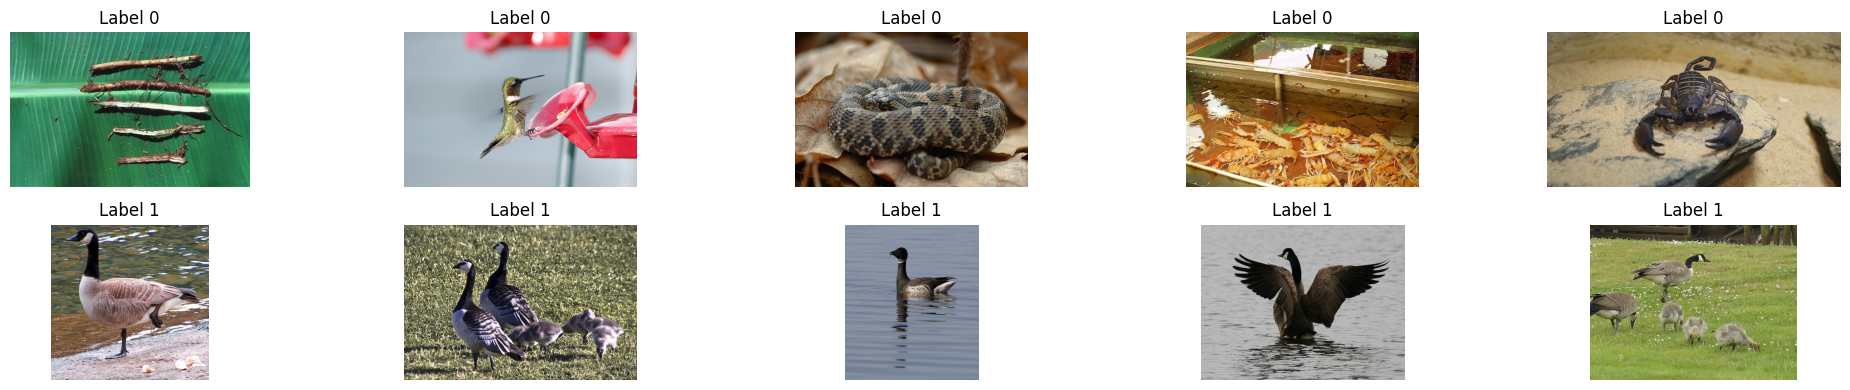

In [ ]:
image_count_and_print("../concept_datasets/binary_dataset_geese", "goose", 5)

In [ ]:
X_geese, y_geese = create_concept_dataset("../concept_datasets/binary_dataset_geese", "clip_ViT-L_14sparse_autoencoder_final.pt", "goose")

Processing 0_other:   0%|          | 0/200 [00:00<?, ?it/s]

Używane urządzenie: cuda



  0%|                                               | 0.00/890M [00:00<?, ?iB/s]
  1%|▎                                     | 6.55M/890M [00:00<00:13, 68.6MiB/s]
  2%|▋                                     | 16.5M/890M [00:00<00:10, 89.4MiB/s]
  3%|█                                     | 25.2M/890M [00:00<00:10, 90.3MiB/s]
  4%|█▍                                    | 35.0M/890M [00:00<00:09, 95.4MiB/s]
  5%|█▉                                    | 44.1M/890M [00:00<00:09, 92.0MiB/s]
  6%|██▍                                    | 56.0M/890M [00:00<00:08, 102MiB/s]
  7%|██▊                                   | 65.8M/890M [00:00<00:11, 77.5MiB/s]
  8%|███▏                                  | 74.0M/890M [00:00<00:12, 68.8MiB/s]
  9%|███▍                                  | 81.5M/890M [00:01<00:11, 71.3MiB/s]
 10%|███▊                                  | 89.9M/890M [00:01<00:11, 75.5MiB/s]
 11%|████▏                                 | 98.4M/890M [00:01<00:10, 79.0MiB/s]
 12%|████▋                 

Używane urządzenie: cuda


Processing 0_other:   1%|          | 2/200 [00:37<58:09, 17.62s/it]  

Używane urządzenie: cuda


Processing 0_other:   2%|▏         | 3/200 [00:47<46:42, 14.22s/it]

Używane urządzenie: cuda


Processing 0_other:   2%|▏         | 4/200 [00:58<41:43, 12.77s/it]

Używane urządzenie: cuda


Processing 0_other:   2%|▎         | 5/200 [01:09<39:15, 12.08s/it]

Używane urządzenie: cuda


Processing 0_other:   3%|▎         | 6/200 [01:20<38:19, 11.85s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▎         | 7/200 [01:30<36:14, 11.27s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▍         | 8/200 [01:40<34:49, 10.88s/it]

Używane urządzenie: cuda


Processing 0_other:   4%|▍         | 9/200 [01:52<35:23, 11.12s/it]

Używane urządzenie: cuda


Processing 0_other:   5%|▌         | 10/200 [02:03<35:23, 11.17s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▌         | 11/200 [02:15<35:33, 11.29s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▌         | 12/200 [02:26<35:16, 11.26s/it]

Używane urządzenie: cuda


Processing 0_other:   6%|▋         | 13/200 [02:37<35:15, 11.31s/it]

Używane urządzenie: cuda


Processing 0_other:   7%|▋         | 14/200 [02:48<34:21, 11.08s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 15/200 [02:58<33:21, 10.82s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 16/200 [03:09<33:37, 10.96s/it]

Używane urządzenie: cuda


Processing 0_other:   8%|▊         | 17/200 [03:20<33:11, 10.88s/it]

Używane urządzenie: cuda


Processing 0_other:   9%|▉         | 18/200 [03:31<33:17, 10.98s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|▉         | 19/200 [03:42<33:15, 11.02s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|█         | 20/200 [03:52<32:11, 10.73s/it]

Używane urządzenie: cuda


Processing 0_other:  10%|█         | 21/200 [04:03<31:37, 10.60s/it]

Używane urządzenie: cuda


Processing 0_other:  11%|█         | 22/200 [04:14<31:52, 10.75s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▏        | 23/200 [04:25<32:01, 10.86s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▏        | 24/200 [04:36<32:13, 10.99s/it]

Używane urządzenie: cuda


Processing 0_other:  12%|█▎        | 25/200 [04:47<32:12, 11.04s/it]

Używane urządzenie: cuda


Processing 0_other:  13%|█▎        | 26/200 [04:57<31:08, 10.74s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▎        | 27/200 [05:08<30:44, 10.66s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▍        | 28/200 [05:19<30:59, 10.81s/it]

Używane urządzenie: cuda


Processing 0_other:  14%|█▍        | 29/200 [05:30<30:36, 10.74s/it]

Używane urządzenie: cuda


Processing 0_other:  15%|█▌        | 30/200 [05:41<30:46, 10.86s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▌        | 31/200 [05:51<30:21, 10.78s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▌        | 32/200 [06:01<29:26, 10.51s/it]

Używane urządzenie: cuda


Processing 0_other:  16%|█▋        | 33/200 [06:12<29:38, 10.65s/it]

Używane urządzenie: cuda


Processing 0_other:  17%|█▋        | 34/200 [06:23<29:22, 10.62s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 35/200 [06:34<29:38, 10.78s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 36/200 [06:45<29:43, 10.88s/it]

Używane urządzenie: cuda


Processing 0_other:  18%|█▊        | 37/200 [06:55<28:48, 10.61s/it]

Używane urządzenie: cuda


Processing 0_other:  19%|█▉        | 38/200 [07:05<28:26, 10.53s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|█▉        | 39/200 [07:17<28:50, 10.75s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|██        | 40/200 [07:27<28:31, 10.70s/it]

Używane urządzenie: cuda


Processing 0_other:  20%|██        | 41/200 [07:39<28:50, 10.89s/it]

Używane urządzenie: cuda


Processing 0_other:  21%|██        | 42/200 [07:50<28:46, 10.93s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▏       | 43/200 [08:00<27:50, 10.64s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▏       | 44/200 [08:10<27:37, 10.63s/it]

Używane urządzenie: cuda


Processing 0_other:  22%|██▎       | 45/200 [08:21<27:42, 10.72s/it]

Używane urządzenie: cuda


Processing 0_other:  23%|██▎       | 46/200 [08:32<27:46, 10.82s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▎       | 47/200 [08:43<27:55, 10.95s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▍       | 48/200 [08:55<27:56, 11.03s/it]

Używane urządzenie: cuda


Processing 0_other:  24%|██▍       | 49/200 [09:05<26:57, 10.71s/it]

Używane urządzenie: cuda


Processing 0_other:  25%|██▌       | 50/200 [09:15<26:50, 10.73s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▌       | 51/200 [09:26<26:50, 10.81s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▌       | 52/200 [09:37<26:42, 10.83s/it]

Używane urządzenie: cuda


Processing 0_other:  26%|██▋       | 53/200 [09:49<27:01, 11.03s/it]

Używane urządzenie: cuda


Processing 0_other:  27%|██▋       | 54/200 [09:59<26:36, 10.94s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 55/200 [10:09<25:44, 10.65s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 56/200 [10:21<26:02, 10.85s/it]

Używane urządzenie: cuda


Processing 0_other:  28%|██▊       | 57/200 [10:32<25:53, 10.86s/it]

Używane urządzenie: cuda


Processing 0_other:  29%|██▉       | 58/200 [10:43<25:57, 10.97s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|██▉       | 59/200 [10:54<26:09, 11.13s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|███       | 60/200 [11:05<25:43, 11.03s/it]

Używane urządzenie: cuda


Processing 0_other:  30%|███       | 61/200 [11:15<24:44, 10.68s/it]

Używane urządzenie: cuda


Processing 0_other:  31%|███       | 62/200 [11:26<24:58, 10.86s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▏      | 63/200 [11:37<24:44, 10.84s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▏      | 64/200 [11:48<24:45, 10.92s/it]

Używane urządzenie: cuda


Processing 0_other:  32%|███▎      | 65/200 [11:59<24:46, 11.01s/it]

Używane urządzenie: cuda


Processing 0_other:  33%|███▎      | 66/200 [12:09<23:54, 10.71s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▎      | 67/200 [12:20<23:26, 10.58s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▍      | 68/200 [12:31<23:41, 10.77s/it]

Używane urządzenie: cuda


Processing 0_other:  34%|███▍      | 69/200 [12:41<23:21, 10.70s/it]

Używane urządzenie: cuda


Processing 0_other:  35%|███▌      | 70/200 [12:53<23:30, 10.85s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▌      | 71/200 [13:04<23:25, 10.89s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▌      | 72/200 [13:14<22:35, 10.59s/it]

Używane urządzenie: cuda


Processing 0_other:  36%|███▋      | 73/200 [13:25<23:03, 10.89s/it]

Używane urządzenie: cuda


Processing 0_other:  37%|███▋      | 74/200 [13:43<27:07, 12.92s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 75/200 [13:53<25:28, 12.23s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 76/200 [14:06<25:37, 12.40s/it]

Używane urządzenie: cuda


Processing 0_other:  38%|███▊      | 77/200 [14:18<25:03, 12.23s/it]

Używane urządzenie: cuda


Processing 0_other:  39%|███▉      | 78/200 [14:34<27:19, 13.44s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|███▉      | 79/200 [14:46<25:45, 12.77s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|████      | 80/200 [14:56<24:24, 12.21s/it]

Używane urządzenie: cuda


Processing 0_other:  40%|████      | 81/200 [15:09<24:32, 12.37s/it]

Używane urządzenie: cuda


Processing 0_other:  41%|████      | 82/200 [15:21<24:17, 12.35s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▏     | 83/200 [15:37<26:12, 13.44s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▏     | 84/200 [15:50<25:42, 13.30s/it]

Używane urządzenie: cuda


Processing 0_other:  42%|████▎     | 85/200 [16:03<25:20, 13.22s/it]

Używane urządzenie: cuda


Processing 0_other:  43%|████▎     | 86/200 [16:17<25:07, 13.23s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▎     | 87/200 [16:30<25:03, 13.31s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▍     | 88/200 [16:43<24:35, 13.18s/it]

Używane urządzenie: cuda


Processing 0_other:  44%|████▍     | 89/200 [16:55<23:31, 12.72s/it]

Używane urządzenie: cuda


Processing 0_other:  45%|████▌     | 90/200 [17:05<22:03, 12.03s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▌     | 91/200 [17:15<20:49, 11.47s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▌     | 92/200 [17:30<22:15, 12.37s/it]

Używane urządzenie: cuda


Processing 0_other:  46%|████▋     | 93/200 [17:43<22:17, 12.50s/it]

Używane urządzenie: cuda


Processing 0_other:  47%|████▋     | 94/200 [17:56<22:39, 12.83s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 95/200 [18:09<22:27, 12.83s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 96/200 [18:23<22:49, 13.17s/it]

Używane urządzenie: cuda


Processing 0_other:  48%|████▊     | 97/200 [18:37<22:57, 13.38s/it]

Używane urządzenie: cuda


Processing 0_other:  49%|████▉     | 98/200 [18:48<21:45, 12.80s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|████▉     | 99/200 [18:59<20:31, 12.20s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|█████     | 100/200 [19:11<20:09, 12.10s/it]

Używane urządzenie: cuda


Processing 0_other:  50%|█████     | 101/200 [19:26<21:13, 12.86s/it]

Używane urządzenie: cuda


Processing 0_other:  51%|█████     | 102/200 [19:39<21:16, 13.02s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▏    | 103/200 [19:52<20:58, 12.97s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▏    | 104/200 [20:06<21:22, 13.36s/it]

Używane urządzenie: cuda


Processing 0_other:  52%|█████▎    | 105/200 [20:21<21:45, 13.74s/it]

Używane urządzenie: cuda


Processing 0_other:  53%|█████▎    | 106/200 [20:35<21:52, 13.97s/it]

Używane urządzenie: cuda


Processing 0_other:  54%|█████▎    | 107/200 [20:48<20:58, 13.54s/it]

Używane urządzenie: cuda


Processing 0_other:  54%|█████▍    | 108/200 [21:02<21:12, 13.84s/it]

Używane urządzenie: cuda


Processing 0_other:  55%|█████▍    | 109/200 [21:15<20:36, 13.58s/it]

Używane urządzenie: cuda


Processing 0_other:  55%|█████▌    | 110/200 [21:30<20:51, 13.90s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▌    | 111/200 [21:45<21:20, 14.39s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▌    | 112/200 [21:58<20:07, 13.72s/it]

Używane urządzenie: cuda


Processing 0_other:  56%|█████▋    | 113/200 [22:10<19:26, 13.40s/it]

Używane urządzenie: cuda


Processing 0_other:  57%|█████▋    | 114/200 [22:23<18:51, 13.15s/it]

Używane urządzenie: cuda


Processing 0_other:  57%|█████▊    | 115/200 [22:35<18:25, 13.00s/it]

Używane urządzenie: cuda


Processing 0_other:  58%|█████▊    | 116/200 [22:46<17:19, 12.38s/it]

Używane urządzenie: cuda


Processing 0_other:  58%|█████▊    | 117/200 [22:57<16:35, 11.99s/it]

Używane urządzenie: cuda


Processing 0_other:  59%|█████▉    | 118/200 [23:08<15:49, 11.57s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|█████▉    | 119/200 [23:22<16:29, 12.22s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|██████    | 120/200 [23:36<16:58, 12.74s/it]

Używane urządzenie: cuda


Processing 0_other:  60%|██████    | 121/200 [23:48<16:32, 12.56s/it]

Używane urządzenie: cuda


Processing 0_other:  61%|██████    | 122/200 [24:02<16:52, 12.98s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▏   | 123/200 [24:13<15:57, 12.43s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▏   | 124/200 [24:24<15:16, 12.06s/it]

Używane urządzenie: cuda


Processing 0_other:  62%|██████▎   | 125/200 [24:36<14:48, 11.84s/it]

Używane urządzenie: cuda


Processing 0_other:  63%|██████▎   | 126/200 [24:46<14:00, 11.36s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▎   | 127/200 [24:56<13:22, 11.00s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▍   | 128/200 [25:07<13:20, 11.11s/it]

Używane urządzenie: cuda


Processing 0_other:  64%|██████▍   | 129/200 [25:18<12:57, 10.96s/it]

Używane urządzenie: cuda


Processing 0_other:  65%|██████▌   | 130/200 [25:29<12:55, 11.08s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▌   | 131/200 [25:42<13:16, 11.54s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▌   | 132/200 [25:52<12:45, 11.26s/it]

Używane urządzenie: cuda


Processing 0_other:  66%|██████▋   | 133/200 [26:02<12:05, 10.82s/it]

Używane urządzenie: cuda


Processing 0_other:  67%|██████▋   | 134/200 [26:13<12:01, 10.94s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 135/200 [26:24<11:47, 10.88s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 136/200 [26:35<11:41, 10.96s/it]

Używane urządzenie: cuda


Processing 0_other:  68%|██████▊   | 137/200 [26:47<11:34, 11.02s/it]

Używane urządzenie: cuda


Processing 0_other:  69%|██████▉   | 138/200 [26:57<11:08, 10.77s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|██████▉   | 139/200 [27:07<10:45, 10.58s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|███████   | 140/200 [27:18<10:45, 10.76s/it]

Używane urządzenie: cuda


Processing 0_other:  70%|███████   | 141/200 [27:29<10:30, 10.68s/it]

Używane urządzenie: cuda


Processing 0_other:  71%|███████   | 142/200 [27:40<10:29, 10.85s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▏  | 143/200 [27:51<10:24, 10.95s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▏  | 144/200 [28:01<09:55, 10.64s/it]

Używane urządzenie: cuda


Processing 0_other:  72%|███████▎  | 145/200 [28:12<09:47, 10.68s/it]

Używane urządzenie: cuda


Processing 0_other:  73%|███████▎  | 146/200 [28:23<09:44, 10.83s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▎  | 147/200 [28:38<10:50, 12.27s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▍  | 148/200 [28:54<11:34, 13.36s/it]

Używane urządzenie: cuda


Processing 0_other:  74%|███████▍  | 149/200 [29:05<10:46, 12.68s/it]

Używane urządzenie: cuda


Processing 0_other:  75%|███████▌  | 150/200 [29:17<10:19, 12.39s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▌  | 151/200 [29:30<10:19, 12.64s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▌  | 152/200 [29:41<09:42, 12.13s/it]

Używane urządzenie: cuda


Processing 0_other:  76%|███████▋  | 153/200 [29:53<09:17, 11.87s/it]

Używane urządzenie: cuda


Processing 0_other:  77%|███████▋  | 154/200 [30:03<08:49, 11.50s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 155/200 [30:13<08:16, 11.03s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 156/200 [30:25<08:17, 11.30s/it]

Używane urządzenie: cuda


Processing 0_other:  78%|███████▊  | 157/200 [30:36<08:02, 11.21s/it]

Używane urządzenie: cuda


Processing 0_other:  79%|███████▉  | 158/200 [30:47<07:47, 11.13s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|███████▉  | 159/200 [30:58<07:37, 11.16s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|████████  | 160/200 [31:09<07:18, 10.97s/it]

Używane urządzenie: cuda


Processing 0_other:  80%|████████  | 161/200 [31:19<06:56, 10.69s/it]

Używane urządzenie: cuda


Processing 0_other:  81%|████████  | 162/200 [31:30<06:52, 10.86s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▏ | 163/200 [31:41<06:38, 10.78s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▏ | 164/200 [31:52<06:33, 10.92s/it]

Używane urządzenie: cuda


Processing 0_other:  82%|████████▎ | 165/200 [32:04<06:33, 11.24s/it]

Używane urządzenie: cuda


Processing 0_other:  83%|████████▎ | 166/200 [32:17<06:42, 11.84s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▎ | 167/200 [32:28<06:16, 11.41s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▍ | 168/200 [32:39<06:05, 11.43s/it]

Używane urządzenie: cuda


Processing 0_other:  84%|████████▍ | 169/200 [32:50<05:50, 11.31s/it]

Używane urządzenie: cuda


Processing 0_other:  85%|████████▌ | 170/200 [33:04<06:04, 12.15s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▌ | 171/200 [33:17<05:57, 12.31s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▌ | 172/200 [33:31<05:59, 12.84s/it]

Używane urządzenie: cuda


Processing 0_other:  86%|████████▋ | 173/200 [33:44<05:47, 12.86s/it]

Używane urządzenie: cuda


Processing 0_other:  87%|████████▋ | 174/200 [33:56<05:25, 12.51s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 175/200 [34:12<05:42, 13.68s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 176/200 [34:23<05:12, 13.01s/it]

Używane urządzenie: cuda


Processing 0_other:  88%|████████▊ | 177/200 [34:34<04:43, 12.32s/it]

Używane urządzenie: cuda


Processing 0_other:  89%|████████▉ | 178/200 [34:46<04:25, 12.07s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|████████▉ | 179/200 [34:58<04:16, 12.19s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|█████████ | 180/200 [35:09<03:53, 11.67s/it]

Używane urządzenie: cuda


Processing 0_other:  90%|█████████ | 181/200 [35:24<04:02, 12.77s/it]

Używane urządzenie: cuda


Processing 0_other:  91%|█████████ | 182/200 [35:34<03:36, 12.02s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▏| 183/200 [35:46<03:23, 11.98s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▏| 184/200 [36:06<03:48, 14.28s/it]

Używane urządzenie: cuda


Processing 0_other:  92%|█████████▎| 185/200 [36:16<03:18, 13.20s/it]

Używane urządzenie: cuda


Processing 0_other:  93%|█████████▎| 186/200 [36:26<02:51, 12.27s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▎| 187/200 [36:39<02:39, 12.27s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▍| 188/200 [36:50<02:23, 11.98s/it]

Używane urządzenie: cuda


Processing 0_other:  94%|█████████▍| 189/200 [37:04<02:16, 12.43s/it]

Używane urządzenie: cuda


Processing 0_other:  95%|█████████▌| 190/200 [37:18<02:09, 13.00s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▌| 191/200 [37:33<02:02, 13.62s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▌| 192/200 [37:48<01:52, 14.09s/it]

Używane urządzenie: cuda


Processing 0_other:  96%|█████████▋| 193/200 [38:00<01:34, 13.52s/it]

Używane urządzenie: cuda


Processing 0_other:  97%|█████████▋| 194/200 [38:13<01:19, 13.29s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 195/200 [38:25<01:04, 12.90s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 196/200 [38:37<00:50, 12.74s/it]

Używane urządzenie: cuda


Processing 0_other:  98%|█████████▊| 197/200 [38:49<00:36, 12.28s/it]

Używane urządzenie: cuda


Processing 0_other:  99%|█████████▉| 198/200 [39:00<00:24, 12.08s/it]

Używane urządzenie: cuda


Processing 0_other: 100%|█████████▉| 199/200 [39:11<00:11, 11.56s/it]

Używane urządzenie: cuda


Processing 1_goose:   0%|          | 0/200 [00:00<?, ?it/s]

Używane urządzenie: cuda


Processing 1_goose:   0%|          | 1/200 [00:11<36:38, 11.05s/it]

Używane urządzenie: cuda


Processing 1_goose:   1%|          | 2/200 [00:21<34:56, 10.59s/it]

Używane urządzenie: cuda


Processing 1_goose:   2%|▏         | 3/200 [00:32<35:16, 10.74s/it]

Używane urządzenie: cuda


Processing 1_goose:   2%|▏         | 4/200 [00:42<34:43, 10.63s/it]

Używane urządzenie: cuda


Processing 1_goose:   2%|▎         | 5/200 [00:52<33:12, 10.22s/it]

Używane urządzenie: cuda


Processing 1_goose:   3%|▎         | 6/200 [01:03<34:10, 10.57s/it]

Używane urządzenie: cuda


Processing 1_goose:   4%|▎         | 7/200 [01:15<35:43, 11.11s/it]

Używane urządzenie: cuda


Processing 1_goose:   4%|▍         | 8/200 [01:26<35:25, 11.07s/it]

Używane urządzenie: cuda


Processing 1_goose:   4%|▍         | 9/200 [01:37<35:26, 11.13s/it]

Używane urządzenie: cuda


Processing 1_goose:   5%|▌         | 10/200 [01:48<34:54, 11.02s/it]

Używane urządzenie: cuda


Processing 1_goose:   6%|▌         | 11/200 [01:58<33:38, 10.68s/it]

Używane urządzenie: cuda


Processing 1_goose:   6%|▌         | 12/200 [02:09<33:47, 10.78s/it]

Używane urządzenie: cuda


Processing 1_goose:   6%|▋         | 13/200 [02:20<33:35, 10.78s/it]

Używane urządzenie: cuda


Processing 1_goose:   7%|▋         | 14/200 [02:31<33:44, 10.88s/it]

Używane urządzenie: cuda


Processing 1_goose:   8%|▊         | 15/200 [02:42<34:01, 11.04s/it]

Używane urządzenie: cuda


Processing 1_goose:   8%|▊         | 16/200 [02:53<33:35, 10.95s/it]

Używane urządzenie: cuda


Processing 1_goose:   8%|▊         | 17/200 [03:03<32:34, 10.68s/it]

Używane urządzenie: cuda


Processing 1_goose:   9%|▉         | 18/200 [03:19<37:24, 12.33s/it]

Używane urządzenie: cuda


Processing 1_goose:  10%|▉         | 19/200 [03:35<40:27, 13.41s/it]

Używane urządzenie: cuda


Processing 1_goose:  10%|█         | 20/200 [03:50<41:26, 13.81s/it]

Używane urządzenie: cuda


Processing 1_goose:  10%|█         | 21/200 [04:02<39:28, 13.23s/it]

Używane urządzenie: cuda


Processing 1_goose:  11%|█         | 22/200 [04:13<37:41, 12.70s/it]

Używane urządzenie: cuda


Processing 1_goose:  12%|█▏        | 23/200 [04:24<35:46, 12.13s/it]

Używane urządzenie: cuda


Processing 1_goose:  12%|█▏        | 24/200 [04:37<36:14, 12.36s/it]

Używane urządzenie: cuda


Processing 1_goose:  12%|█▎        | 25/200 [04:48<34:59, 12.00s/it]

Używane urządzenie: cuda


Processing 1_goose:  13%|█▎        | 26/200 [04:59<33:44, 11.64s/it]

Używane urządzenie: cuda


Processing 1_goose:  14%|█▎        | 27/200 [05:12<34:47, 12.07s/it]

Używane urządzenie: cuda


Processing 1_goose:  14%|█▍        | 28/200 [05:25<35:13, 12.29s/it]

Używane urządzenie: cuda


Processing 1_goose:  14%|█▍        | 29/200 [05:36<34:07, 11.98s/it]

Używane urządzenie: cuda


Processing 1_goose:  15%|█▌        | 30/200 [05:46<32:11, 11.36s/it]

Używane urządzenie: cuda


Processing 1_goose:  16%|█▌        | 31/200 [05:57<31:31, 11.19s/it]

Używane urządzenie: cuda


Processing 1_goose:  16%|█▌        | 32/200 [06:08<31:18, 11.18s/it]

Używane urządzenie: cuda


Processing 1_goose:  16%|█▋        | 33/200 [06:19<31:08, 11.19s/it]

Używane urządzenie: cuda


Processing 1_goose:  17%|█▋        | 34/200 [06:31<31:08, 11.26s/it]

Używane urządzenie: cuda


Processing 1_goose:  18%|█▊        | 35/200 [06:42<30:45, 11.19s/it]

Używane urządzenie: cuda


Processing 1_goose:  18%|█▊        | 36/200 [06:52<29:33, 10.82s/it]

Używane urządzenie: cuda


Processing 1_goose:  18%|█▊        | 37/200 [07:02<29:25, 10.83s/it]

Używane urządzenie: cuda


Processing 1_goose:  19%|█▉        | 38/200 [07:14<29:24, 10.89s/it]

Używane urządzenie: cuda


Processing 1_goose:  20%|█▉        | 39/200 [07:24<29:16, 10.91s/it]

Używane urządzenie: cuda


Processing 1_goose:  20%|██        | 40/200 [07:36<29:30, 11.07s/it]

Używane urządzenie: cuda


Processing 1_goose:  20%|██        | 41/200 [07:49<30:49, 11.63s/it]

Używane urządzenie: cuda


Processing 1_goose:  21%|██        | 42/200 [07:59<29:35, 11.24s/it]

Używane urządzenie: cuda


Processing 1_goose:  22%|██▏       | 43/200 [08:16<33:32, 12.82s/it]

Używane urządzenie: cuda


Processing 1_goose:  22%|██▏       | 44/200 [08:32<36:19, 13.97s/it]

Używane urządzenie: cuda


Processing 1_goose:  22%|██▎       | 45/200 [08:44<34:02, 13.18s/it]

Używane urządzenie: cuda


Processing 1_goose:  23%|██▎       | 46/200 [08:54<31:46, 12.38s/it]

Używane urządzenie: cuda


Processing 1_goose:  24%|██▎       | 47/200 [09:04<29:49, 11.70s/it]

Używane urządzenie: cuda


Processing 1_goose:  24%|██▍       | 48/200 [09:16<29:42, 11.73s/it]

Używane urządzenie: cuda


Processing 1_goose:  24%|██▍       | 49/200 [09:37<36:40, 14.57s/it]

Używane urządzenie: cuda


Processing 1_goose:  25%|██▌       | 50/200 [09:58<40:54, 16.37s/it]

Używane urządzenie: cuda


Processing 1_goose:  26%|██▌       | 51/200 [10:15<41:28, 16.70s/it]

Używane urządzenie: cuda


Processing 1_goose:  26%|██▌       | 52/200 [10:26<36:33, 14.82s/it]

Używane urządzenie: cuda


Processing 1_goose:  26%|██▋       | 53/200 [10:37<33:48, 13.80s/it]

Używane urządzenie: cuda


Processing 1_goose:  27%|██▋       | 54/200 [10:51<33:24, 13.73s/it]

Używane urządzenie: cuda


Processing 1_goose:  28%|██▊       | 55/200 [11:05<33:53, 14.02s/it]

Używane urządzenie: cuda


Processing 1_goose:  28%|██▊       | 56/200 [11:22<35:30, 14.79s/it]

Używane urządzenie: cuda


Processing 1_goose:  28%|██▊       | 57/200 [11:43<39:26, 16.55s/it]

Używane urządzenie: cuda


Processing 1_goose:  29%|██▉       | 58/200 [12:02<40:48, 17.25s/it]

Używane urządzenie: cuda


Processing 1_goose:  30%|██▉       | 59/200 [12:19<40:19, 17.16s/it]

Używane urządzenie: cuda


Processing 1_goose:  30%|███       | 60/200 [12:29<35:15, 15.11s/it]

Używane urządzenie: cuda


Processing 1_goose:  30%|███       | 61/200 [12:41<32:53, 14.19s/it]

Używane urządzenie: cuda


Processing 1_goose:  31%|███       | 62/200 [12:53<30:54, 13.44s/it]

Używane urządzenie: cuda


Processing 1_goose:  32%|███▏      | 63/200 [13:04<28:58, 12.69s/it]

Używane urządzenie: cuda


Processing 1_goose:  32%|███▏      | 64/200 [13:15<28:01, 12.36s/it]

Używane urządzenie: cuda


Processing 1_goose:  32%|███▎      | 65/200 [13:35<32:56, 14.64s/it]

Używane urządzenie: cuda


Processing 1_goose:  33%|███▎      | 66/200 [13:54<35:46, 16.02s/it]

Używane urządzenie: cuda


Processing 1_goose:  34%|███▎      | 67/200 [14:12<36:29, 16.47s/it]

Używane urządzenie: cuda


Processing 1_goose:  34%|███▍      | 68/200 [14:23<32:49, 14.92s/it]

Używane urządzenie: cuda


Processing 1_goose:  34%|███▍      | 69/200 [14:33<29:19, 13.43s/it]

Używane urządzenie: cuda


Processing 1_goose:  35%|███▌      | 70/200 [14:44<27:08, 12.53s/it]

Używane urządzenie: cuda


Processing 1_goose:  36%|███▌      | 71/200 [14:55<26:01, 12.11s/it]

Używane urządzenie: cuda


Processing 1_goose:  36%|███▌      | 72/200 [15:06<25:09, 11.79s/it]

Używane urządzenie: cuda


Processing 1_goose:  36%|███▋      | 73/200 [15:17<24:49, 11.73s/it]

Używane urządzenie: cuda


Processing 1_goose:  37%|███▋      | 74/200 [15:29<24:18, 11.58s/it]

Używane urządzenie: cuda


Processing 1_goose:  38%|███▊      | 75/200 [15:39<23:17, 11.18s/it]

Używane urządzenie: cuda


Processing 1_goose:  38%|███▊      | 76/200 [15:49<22:38, 10.95s/it]

Używane urządzenie: cuda


Processing 1_goose:  38%|███▊      | 77/200 [16:01<22:41, 11.07s/it]

Używane urządzenie: cuda


Processing 1_goose:  39%|███▉      | 78/200 [16:11<22:18, 10.97s/it]

Używane urządzenie: cuda


Processing 1_goose:  40%|███▉      | 79/200 [16:23<22:21, 11.09s/it]

Używane urządzenie: cuda


Processing 1_goose:  40%|████      | 80/200 [16:34<22:11, 11.09s/it]

Używane urządzenie: cuda


Processing 1_goose:  40%|████      | 81/200 [16:44<21:28, 10.83s/it]

Używane urządzenie: cuda


Processing 1_goose:  41%|████      | 82/200 [16:56<21:46, 11.07s/it]

Używane urządzenie: cuda


Processing 1_goose:  42%|████▏     | 83/200 [17:07<21:48, 11.18s/it]

Używane urządzenie: cuda


Processing 1_goose:  42%|████▏     | 84/200 [17:18<21:18, 11.02s/it]

Używane urządzenie: cuda


Processing 1_goose:  42%|████▎     | 85/200 [17:29<21:19, 11.13s/it]

Używane urządzenie: cuda


Processing 1_goose:  43%|████▎     | 86/200 [17:40<21:09, 11.13s/it]

Używane urządzenie: cuda


Processing 1_goose:  44%|████▎     | 87/200 [17:50<20:21, 10.81s/it]

Używane urządzenie: cuda


Processing 1_goose:  44%|████▍     | 88/200 [18:01<20:16, 10.87s/it]

Używane urządzenie: cuda


Processing 1_goose:  44%|████▍     | 89/200 [18:12<20:13, 10.94s/it]

Używane urządzenie: cuda


Processing 1_goose:  45%|████▌     | 90/200 [18:23<20:03, 10.94s/it]

Używane urządzenie: cuda


Processing 1_goose:  46%|████▌     | 91/200 [18:35<20:07, 11.08s/it]

Używane urządzenie: cuda


Processing 1_goose:  46%|████▌     | 92/200 [18:46<20:10, 11.21s/it]

Używane urządzenie: cuda


Processing 1_goose:  46%|████▋     | 93/200 [18:56<19:17, 10.82s/it]

Używane urządzenie: cuda


Processing 1_goose:  47%|████▋     | 94/200 [19:07<19:20, 10.94s/it]

Używane urządzenie: cuda


Processing 1_goose:  48%|████▊     | 95/200 [19:18<19:08, 10.94s/it]

Używane urządzenie: cuda


Processing 1_goose:  48%|████▊     | 96/200 [19:30<19:06, 11.03s/it]

Używane urządzenie: cuda


Processing 1_goose:  48%|████▊     | 97/200 [19:41<19:08, 11.15s/it]

Używane urządzenie: cuda


Processing 1_goose:  49%|████▉     | 98/200 [19:52<18:53, 11.11s/it]

Używane urządzenie: cuda


Processing 1_goose:  50%|████▉     | 99/200 [20:02<18:09, 10.79s/it]

Używane urządzenie: cuda


Processing 1_goose:  50%|█████     | 100/200 [20:14<18:20, 11.01s/it]

Używane urządzenie: cuda


Processing 1_goose:  50%|█████     | 101/200 [20:24<18:03, 10.94s/it]

Używane urządzenie: cuda


Processing 1_goose:  51%|█████     | 102/200 [20:36<18:02, 11.05s/it]

Używane urządzenie: cuda


Processing 1_goose:  52%|█████▏    | 103/200 [20:47<18:04, 11.18s/it]

Używane urządzenie: cuda


Processing 1_goose:  52%|█████▏    | 104/200 [20:57<17:26, 10.90s/it]

Używane urządzenie: cuda


Processing 1_goose:  52%|█████▎    | 105/200 [21:08<16:58, 10.72s/it]

Używane urządzenie: cuda


Processing 1_goose:  53%|█████▎    | 106/200 [21:19<17:09, 10.95s/it]

Używane urządzenie: cuda


Processing 1_goose:  54%|█████▎    | 107/200 [21:30<16:47, 10.84s/it]

Używane urządzenie: cuda


Processing 1_goose:  54%|█████▍    | 108/200 [21:41<16:55, 11.04s/it]

Używane urządzenie: cuda


Processing 1_goose:  55%|█████▍    | 109/200 [21:52<16:44, 11.04s/it]

Używane urządzenie: cuda


Processing 1_goose:  55%|█████▌    | 110/200 [22:02<16:03, 10.71s/it]

Używane urządzenie: cuda


Processing 1_goose:  56%|█████▌    | 111/200 [22:13<16:04, 10.84s/it]

Używane urządzenie: cuda


Processing 1_goose:  56%|█████▌    | 112/200 [22:24<15:57, 10.88s/it]

Używane urządzenie: cuda


Processing 1_goose:  56%|█████▋    | 113/200 [22:35<15:51, 10.94s/it]

Używane urządzenie: cuda


Processing 1_goose:  57%|█████▋    | 114/200 [22:47<15:51, 11.07s/it]

Używane urządzenie: cuda


Processing 1_goose:  57%|█████▊    | 115/200 [22:57<15:29, 10.93s/it]

Używane urządzenie: cuda


Processing 1_goose:  58%|█████▊    | 116/200 [23:08<15:00, 10.72s/it]

Używane urządzenie: cuda


Processing 1_goose:  58%|█████▊    | 117/200 [23:19<15:08, 10.94s/it]

Używane urządzenie: cuda


Processing 1_goose:  59%|█████▉    | 118/200 [23:30<14:50, 10.86s/it]

Używane urządzenie: cuda


Processing 1_goose:  60%|█████▉    | 119/200 [23:41<14:54, 11.04s/it]

Używane urządzenie: cuda


Processing 1_goose:  60%|██████    | 120/200 [23:52<14:48, 11.11s/it]

Używane urządzenie: cuda


Processing 1_goose:  60%|██████    | 121/200 [24:03<14:18, 10.87s/it]

Używane urządzenie: cuda


Processing 1_goose:  61%|██████    | 122/200 [24:13<13:59, 10.76s/it]

Używane urządzenie: cuda


Processing 1_goose:  62%|██████▏   | 123/200 [24:25<14:13, 11.09s/it]

Używane urządzenie: cuda


Processing 1_goose:  62%|██████▏   | 124/200 [24:36<13:56, 11.01s/it]

Używane urządzenie: cuda


Processing 1_goose:  62%|██████▎   | 125/200 [24:47<13:51, 11.09s/it]

Używane urządzenie: cuda


Processing 1_goose:  63%|██████▎   | 126/200 [24:58<13:43, 11.13s/it]

Używane urządzenie: cuda


Processing 1_goose:  64%|██████▎   | 127/200 [25:08<13:07, 10.79s/it]

Używane urządzenie: cuda


Processing 1_goose:  64%|██████▍   | 128/200 [25:19<12:50, 10.70s/it]

Używane urządzenie: cuda


Processing 1_goose:  64%|██████▍   | 129/200 [25:30<12:52, 10.88s/it]

Używane urządzenie: cuda


Processing 1_goose:  65%|██████▌   | 130/200 [25:41<12:42, 10.89s/it]

Używane urządzenie: cuda


Processing 1_goose:  66%|██████▌   | 131/200 [25:53<12:41, 11.04s/it]

Używane urządzenie: cuda


Processing 1_goose:  66%|██████▌   | 132/200 [26:04<12:31, 11.05s/it]

Używane urządzenie: cuda


Processing 1_goose:  66%|██████▋   | 133/200 [26:14<12:02, 10.79s/it]

Używane urządzenie: cuda


Processing 1_goose:  67%|██████▋   | 134/200 [26:25<11:55, 10.85s/it]

Używane urządzenie: cuda


Processing 1_goose:  68%|██████▊   | 135/200 [26:36<11:50, 10.93s/it]

Używane urządzenie: cuda


Processing 1_goose:  68%|██████▊   | 136/200 [26:47<11:41, 10.96s/it]

Używane urządzenie: cuda


Processing 1_goose:  68%|██████▊   | 137/200 [26:58<11:37, 11.07s/it]

Używane urządzenie: cuda


Processing 1_goose:  69%|██████▉   | 138/200 [27:09<11:15, 10.90s/it]

Używane urządzenie: cuda


Processing 1_goose:  70%|██████▉   | 139/200 [27:19<10:52, 10.70s/it]

Używane urządzenie: cuda


Processing 1_goose:  70%|███████   | 140/200 [27:30<10:54, 10.91s/it]

Używane urządzenie: cuda


Processing 1_goose:  70%|███████   | 141/200 [27:41<10:44, 10.92s/it]

Używane urządzenie: cuda


Processing 1_goose:  71%|███████   | 142/200 [27:53<10:39, 11.03s/it]

Używane urządzenie: cuda


Processing 1_goose:  72%|███████▏  | 143/200 [28:04<10:34, 11.13s/it]

Używane urządzenie: cuda


Processing 1_goose:  72%|███████▏  | 144/200 [28:14<10:07, 10.85s/it]

Używane urządzenie: cuda


Processing 1_goose:  72%|███████▎  | 145/200 [28:24<09:47, 10.69s/it]

Używane urządzenie: cuda


Processing 1_goose:  73%|███████▎  | 146/200 [28:36<09:47, 10.88s/it]

Używane urządzenie: cuda


Processing 1_goose:  74%|███████▎  | 147/200 [28:47<09:35, 10.86s/it]

Używane urządzenie: cuda


Processing 1_goose:  74%|███████▍  | 148/200 [28:58<09:35, 11.06s/it]

Używane urządzenie: cuda


Processing 1_goose:  74%|███████▍  | 149/200 [29:09<09:22, 11.02s/it]

Używane urządzenie: cuda


Processing 1_goose:  75%|███████▌  | 150/200 [29:19<08:57, 10.75s/it]

Używane urządzenie: cuda


Processing 1_goose:  76%|███████▌  | 151/200 [29:30<08:49, 10.82s/it]

Używane urządzenie: cuda


Processing 1_goose:  76%|███████▌  | 152/200 [29:41<08:42, 10.89s/it]

Używane urządzenie: cuda


Processing 1_goose:  76%|███████▋  | 153/200 [29:52<08:34, 10.95s/it]

Używane urządzenie: cuda


Processing 1_goose:  77%|███████▋  | 154/200 [30:04<08:29, 11.07s/it]

Używane urządzenie: cuda


Processing 1_goose:  78%|███████▊  | 155/200 [30:14<08:12, 10.95s/it]

Używane urządzenie: cuda


Processing 1_goose:  78%|███████▊  | 156/200 [30:24<07:48, 10.65s/it]

Używane urządzenie: cuda


Processing 1_goose:  78%|███████▊  | 157/200 [30:36<07:47, 10.87s/it]

Używane urządzenie: cuda


Processing 1_goose:  79%|███████▉  | 158/200 [30:46<07:33, 10.81s/it]

Używane urządzenie: cuda


Processing 1_goose:  80%|███████▉  | 159/200 [30:58<07:30, 10.98s/it]

Używane urządzenie: cuda


Processing 1_goose:  80%|████████  | 160/200 [31:09<07:23, 11.09s/it]

Używane urządzenie: cuda


Processing 1_goose:  80%|████████  | 161/200 [31:19<07:01, 10.82s/it]

Używane urządzenie: cuda


Processing 1_goose:  81%|████████  | 162/200 [31:30<06:50, 10.79s/it]

Używane urządzenie: cuda


Processing 1_goose:  82%|████████▏ | 163/200 [31:41<06:44, 10.92s/it]

Używane urządzenie: cuda


Processing 1_goose:  82%|████████▏ | 164/200 [31:52<06:33, 10.93s/it]

Używane urządzenie: cuda


Processing 1_goose:  82%|████████▎ | 165/200 [32:04<06:27, 11.06s/it]

Używane urządzenie: cuda


Processing 1_goose:  83%|████████▎ | 166/200 [32:14<06:13, 10.97s/it]

Używane urządzenie: cuda


Processing 1_goose:  84%|████████▎ | 167/200 [32:24<05:53, 10.70s/it]

Używane urządzenie: cuda


Processing 1_goose:  84%|████████▍ | 168/200 [32:36<05:48, 10.88s/it]

Używane urządzenie: cuda


Processing 1_goose:  84%|████████▍ | 169/200 [32:47<05:37, 10.90s/it]

Używane urządzenie: cuda


Processing 1_goose:  85%|████████▌ | 170/200 [32:58<05:29, 10.97s/it]

Używane urządzenie: cuda


Processing 1_goose:  86%|████████▌ | 171/200 [33:09<05:22, 11.11s/it]

Używane urządzenie: cuda


Processing 1_goose:  86%|████████▌ | 172/200 [33:20<05:05, 10.91s/it]

Używane urządzenie: cuda


Processing 1_goose:  86%|████████▋ | 173/200 [33:30<04:51, 10.79s/it]

Używane urządzenie: cuda


Processing 1_goose:  87%|████████▋ | 174/200 [33:42<04:45, 11.00s/it]

Używane urządzenie: cuda


Processing 1_goose:  88%|████████▊ | 175/200 [33:52<04:33, 10.95s/it]

Używane urządzenie: cuda


Processing 1_goose:  88%|████████▊ | 176/200 [34:04<04:25, 11.05s/it]

Używane urządzenie: cuda


Processing 1_goose:  88%|████████▊ | 177/200 [34:15<04:16, 11.14s/it]

Używane urządzenie: cuda


Processing 1_goose:  89%|████████▉ | 178/200 [34:25<03:58, 10.82s/it]

Używane urządzenie: cuda


Processing 1_goose:  90%|████████▉ | 179/200 [34:36<03:44, 10.69s/it]

Używane urządzenie: cuda


Processing 1_goose:  90%|█████████ | 180/200 [34:47<03:38, 10.91s/it]

Używane urządzenie: cuda


Processing 1_goose:  90%|█████████ | 181/200 [34:57<03:25, 10.79s/it]

Używane urządzenie: cuda


Processing 1_goose:  91%|█████████ | 182/200 [35:09<03:18, 11.01s/it]

Używane urządzenie: cuda


Processing 1_goose:  92%|█████████▏| 183/200 [35:20<03:08, 11.06s/it]

Używane urządzenie: cuda


Processing 1_goose:  92%|█████████▏| 184/200 [35:30<02:52, 10.78s/it]

Używane urządzenie: cuda


Processing 1_goose:  92%|█████████▎| 185/200 [35:41<02:42, 10.83s/it]

Używane urządzenie: cuda


Processing 1_goose:  93%|█████████▎| 186/200 [35:52<02:33, 10.93s/it]

Używane urządzenie: cuda


Processing 1_goose:  94%|█████████▎| 187/200 [36:03<02:22, 10.93s/it]

Używane urządzenie: cuda


Processing 1_goose:  94%|█████████▍| 188/200 [36:15<02:12, 11.07s/it]

Używane urządzenie: cuda


Processing 1_goose:  94%|█████████▍| 189/200 [36:26<02:01, 11.05s/it]

Używane urządzenie: cuda


Processing 1_goose:  95%|█████████▌| 190/200 [36:36<01:46, 10.69s/it]

Używane urządzenie: cuda


Processing 1_goose:  96%|█████████▌| 191/200 [36:47<01:37, 10.86s/it]

Używane urządzenie: cuda


Processing 1_goose:  96%|█████████▌| 192/200 [36:58<01:26, 10.84s/it]

Używane urządzenie: cuda


Processing 1_goose:  96%|█████████▋| 193/200 [37:09<01:16, 10.95s/it]

Używane urządzenie: cuda


Processing 1_goose:  97%|█████████▋| 194/200 [37:20<01:06, 11.05s/it]

Używane urządzenie: cuda


Processing 1_goose:  98%|█████████▊| 195/200 [37:30<00:54, 10.81s/it]

Używane urządzenie: cuda


Processing 1_goose:  98%|█████████▊| 196/200 [37:41<00:42, 10.67s/it]

Używane urządzenie: cuda


Processing 1_goose:  98%|█████████▊| 197/200 [37:52<00:32, 10.90s/it]

Używane urządzenie: cuda


Processing 1_goose:  99%|█████████▉| 198/200 [38:03<00:21, 10.95s/it]

Używane urządzenie: cuda


Processing 1_goose: 100%|█████████▉| 199/200 [38:15<00:11, 11.09s/it]

Używane urządzenie: cuda


Processing 1_goose: 100%|██████████| 200/200 [38:26<00:00, 11.53s/it]
<ipython-input-3-8f9e9be1d0f8>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_tensor = torch.tensor(X, dtype=torch.float32)
